# An√°lisis Tiempo-Historia no Lineal con OpenSeesPy
Este notebook gu√≠a paso a paso el modelado, an√°lisis y evaluaci√≥n din√°mica de una estructura tridimensional irregular usando OpenSeesPy.

## 1. Instalaci√≥n de Dependencias
Instala las librer√≠as necesarias para ejecutar el modelo en Google Colab.

In [63]:
# !pip install openseespy ezdxf matplotlib opsvis vfo scipy

Importaci√≥n de librerias en entorno

In [64]:
import openseespy.opensees as ops
import opsvis as opsv
import ezdxf
import matplotlib.pyplot as plt
import numpy as np
import vfo.vfo as vfo
import time
from tqdm import tqdm  # Necesitar√°s instalar esta librer√≠a: pip install tqdm
import pandas as pd
from pathlib import Path
import os

## 2. Definici√≥n de Unidades y Constantes F√≠sicas
Define las unidades base (metro, segundo, kilogramo) y derivadas (newton, pascal, etc.) que se usar√°n en todos los c√°lculos del modelo.

In [65]:
# Unidades Base
m = 1
kg = 1
s = 1
# Otras Unidades
cm = 0.01*m
N = kg*m/s**2
kN = 1000*N
kgf = 9.80665*N
tonf = 1000*kgf
Pa = N/m**2
MPa = 1000*Pa
# Constantes F√≠sicas
g = 9.80665 * m/s**2

# Densidad del concreto
concrete_density = 2400 * kg / m**3

## 3. Par√°metros del Material
Aqu√≠ se definen las propiedades del acero y del concreto.

**F√≥rmulas clave:**
- $E_c = 15100 \cdot \sqrt{f'_c}$ (kgf/cm¬≤)
- $G = \frac{E}{2(1 + \nu)}$

Tambi√©n se establecen los par√°metros de comportamiento no lineal para `Concrete02`.

In [66]:
# Propiedades del acero
fy = 4200 * kgf / cm**2  # L√≠mite de fluencia del acero
Es = 2.1 * 10**6 * kgf / cm**2  # M√≥dulo de elasticidad del acero

# Propiedades del concreto
fc = 210  # Resistencia a la compresi√≥n del concreto (kg/cm^2)
E = 15100 * fc**0.5 * kgf / cm**2  # M√≥dulo de elasticidad del concreto
G = 0.5 * E / (1 + 0.2)  # M√≥dulo de corte del concreto
fc = fc * kgf / cm**2  # Convertir fc a las unidades adecuadas
cover = 4 * cm  # Recubrimiento de vigas y columnas

# Par√°metros del concreto no lineal
fc1 = -fc  # Resistencia a la compresi√≥n (negativa para simular compresi√≥n)
Ec1 = E  # M√≥dulo de elasticidad del concreto
nuc1 = 0.2  # Coeficiente de Poisson del concreto
Gc1 = Ec1 / (2 * (1 + nuc1))  # M√≥dulo de corte del concreto

# Propiedades del concreto confinado
Kfc = 1.0  # Ratio de resistencia del concreto confinado respecto al no confinado
Kres = 0.2  # Ratio de resistencia residual respecto a la m√°xima
fpc1 = Kfc * fc1  # Resistencia m√°xima del concreto confinado
epsc01 = 2 * fpc1 / Ec1  # Deformaci√≥n unitaria correspondiente a fpc1
fpcu1 = Kres * fpc1  # Resistencia residual del concreto confinado
epsU1 = 5 * epsc01  # Deformaci√≥n unitaria m√°xima del concreto confinado
lambda1 = 0.1  # Factor para definir el descenso de la curva de esfuerzo-deformaci√≥n

# Propiedades del concreto no confinado
fpc2 = fc1  # Resistencia m√°xima del concreto no confinado
epsc02 = -0.003  # Deformaci√≥n unitaria correspondiente a fpc2
fpcu2 = Kres * fpc2  # Resistencia residual del concreto no confinado
epsU2 = -0.006  # Deformaci√≥n unitaria m√°xima del concreto no confinado

# Propiedades de resistencia a la tracci√≥n del concreto
ft1 = -0.14 * fpc1  # Resistencia a la tracci√≥n para concreto confinado
ft2 = -0.14 * fpc2  # Resistencia a la tracci√≥n para concreto no confinado
Ets = ft2 / 0.002  # M√≥dulo de elasticidad en la zona de tracci√≥n

# Densidad del concreto
rho = 2400 * kg / m**3  # Densidad del concreto

## 4. Clases y Funciones Auxiliares

Este m√≥dulo contiene todas las definiciones necesarias para:
1. Procesar archivos CAD (DXF)
2. Modelar secciones estructurales
3. Leer registros s√≠smicos
4. Crear secciones de fibras para an√°lisis

**Componentes principales:**
- `DXFProcessor`: Conversor CAD a modelo anal√≠tico
- `SeccionRectangular`: Geometr√≠a de vigas/columnas
- `Muro`: Geometr√≠a de muros estructurales  
- `Section`: Constructor de secciones de fibras
- `StructureModel`: Ensamblador del modelo completo
- `ReadRecord`: Lector de acelerogramas

In [67]:
### ------------------------------------------------------------
### 4.1 Procesamiento de Archivos DXF (CAD a Modelo Estructural)
### ------------------------------------------------------------

def DXFProcessor(title_file):
    """
    Procesa un archivo DXF y extrae la informaci√≥n estructural para an√°lisis en OpenSees.

    Par√°metros:
    -----------
    title_file : str
        Ruta del archivo DXF que contiene el modelo estructural

    Retorna:
    --------
    dict: Diccionario con toda la informaci√≥n estructural procesada:
        - Nodes: Lista de nodos con coordenadas y propiedades
        - Elems: Lista de elementos con conectividad y propiedades
        - sec_vig: Secciones de vigas
        - sec_col: Secciones de columnas
        - nsec_vig: N√∫mero de secciones de vigas
        - nsec_col: N√∫mero de secciones de columnas
        - Diap: Nodos maestros para diafragmas r√≠gidos
        - AreaPlanta: √Årea de la planta estructural
        - Rest_node: Nodos con restricciones en la base
        - Levels: Alturas de los niveles del edificio
    """

    # Leer archivo DXF usando ezdxf
    doc = ezdxf.readfile(title_file)
    msp = doc.modelspace()  # Obtener el espacio del modelo (model space)

    # Inicializaci√≥n de listas para almacenamiento temporal
    points, lines, polylines = [], [], []  # Entidades geom√©tricas b√°sicas
    elements, diaphragms = [], []          # Elementos estructurales y diafragmas
    nodes, rest_nodes = [], []             # Nodos y nodos restringidos
    tag_nodes = 0                          # Contador para tags de nodos
    n_elems_init = 0                       # Contador para tags de elementos

    # ------------------------------
    # 4.1.1 Extracci√≥n de Entidades
    # ------------------------------
    for entity in msp:
        # Puntos (nodos potenciales)
        if entity.dxftype() == "POINT":
            location = list(entity.dxf.location)  # Coordenadas XYZ
            points.append([entity.dxf.layer, *location])  # Guardar con info de capa

        # L√≠neas (vigas/columnas potenciales)
        elif entity.dxftype() == "LINE":
            start = list(entity.dxf.start)  # Punto inicial
            end = list(entity.dxf.end)      # Punto final
            lines.append([entity.dxf.layer, start, end])  # Guardar con info de capa

        # Polil√≠neas (muros potenciales)
        elif entity.dxftype() == "LWPOLYLINE":
            vertices = list(entity.vertices_in_wcs())  # Todos los v√©rtices
            polylines.append([entity.dxf.layer] + [list(v) for v in vertices])

    # --------------------------
    # 4.1.2 Procesamiento Nodos
    # --------------------------
    for point in points:
        # Determinar tipo de nodo seg√∫n convenci√≥n de nombres de capas
        node_type = point[0].split("_")[2]  # Ej: "Nodo_centrales_1" -> "centrales"

        # Asignar masa nodal seg√∫n tipo (para an√°lisis din√°mico)
        mass_factors = {
            "centrales": 1.0,    # Nodos centrales: masa completa
            "esquinero": 0.5,     # Nodos de esquina: mitad de masa
            "externo": 0.25       # Nodos de borde: cuarto de masa
        }
        node_mass = mass_factors.get(node_type, 1.0)  # Default a 1.0 si no coincide

        # Crear nodo con tag, coordenadas XYZ y factor de masa
        nodes.append([tag_nodes, point[1], point[2], point[3], node_mass])
        tag_nodes += 1

    # Funci√≥n auxiliar para redondeo de coordenadas
    def round_coordinates(coords, precision=3):
        """Redondea coordenadas para evitar errores de precisi√≥n en comparaciones"""
        return [round(coord, precision) for coord in coords]

    # ---------------------------------
    # 4.1.3 Procesamiento Conectividad
    # ---------------------------------

    # Procesar l√≠neas (vigas/columnas)
    for line in lines:
        # Redondear coordenadas de extremos
        line[1] = round_coordinates(line[1])  # Punto inicial
        line[2] = round_coordinates(line[2])  # Punto final

        # Reemplazar coordenadas con tags de nodos
        for node in nodes:
            node_coords = round_coordinates(node[1:4])  # Coordenadas XYZ del nodo

            if line[1] == node_coords:
                line[1] = node[0]  # Reemplazar coordenadas con tag de nodo
            elif line[2] == node_coords:
                line[2] = node[0]

    # Procesar polil√≠neas (muros)
    for polyline in polylines:
        # Redondear coordenadas de v√©rtices (primeros 4 v√©rtices)
        for i in range(1, 5):
            polyline[i] = round_coordinates(polyline[i])

        # Reemplazar coordenadas con tags de nodos
        for node in nodes:
            node_coords = round_coordinates(node[1:4])
            for i in range(1, 5):
                if polyline[i] == node_coords:
                    polyline[i] = node[0]

    # --------------------------------
    # 4.1.4 Creaci√≥n de Elementos
    # --------------------------------

    # Listas para secciones √∫nicas
    column_sections, beam_sections = [], []

    # Procesar l√≠neas como elementos estructurales
    for line in lines:
        # Extraer propiedades de la capa (formato: Tipo_Dim1_Dim2)
        layer_parts = line[0].split("_")
        element_type = layer_parts[1]  # "C" para columna, "V" para viga
        dim1, dim2 = float(layer_parts[2]), float(layer_parts[3])  # Dimensiones

        # Columnas
        if element_type == "C":
            column_sections.append([dim1, dim2])
            # [tag, nodoI, nodoJ, b, h, tipo(1=col), material_tag]
            elements.append([n_elems_init, line[1], line[2], dim1, dim2, 1, 1])

        # Vigas
        elif element_type == "V":
            beam_sections.append([dim1, dim2])
            # [tag, nodoI, nodoJ, b, h, tipo(2=viga), material_tag]
            elements.append([n_elems_init, line[1], line[2], dim1, dim2, 2, 2])

        n_elems_init += 1

    # Procesar polil√≠neas como muros
    for polyline in polylines:
        wall_type = polyline[0].split("_")[1]  # "Mx" o "My"

        if wall_type in ["Mx", "My"]:
            thickness = float(polyline[0].split("_")[2])  # Espesor del muro
            wall_code = 3 if wall_type == "Mx" else 4      # 3=Muro X, 4=Muro Y

            # [tag, nodo1, nodo2, nodo3, nodo4, tipo, espesor]
            elements.append([
                n_elems_init,
                polyline[1], polyline[2], polyline[3], polyline[4],
                wall_code, thickness
            ])
            n_elems_init += 1

    # --------------------------------
    # 4.1.5 Post-procesamiento
    # --------------------------------

    # Asegurar coordenadas positivas (sistema de referencia consistente)
    for node in nodes:
        node[1:4] = [abs(round(coord, 2)) for coord in node[1:4]]

    # Identificar nodos en la base (Z=0) para restricciones
    rest_nodes = [node for node in nodes if node[3] == 0]

    # Calcular centros de masa por nivel para diafragmas r√≠gidos
    levels = sorted({node[3] for node in nodes})  # Niveles √∫nicos ordenados

    for level_idx, level_z in enumerate(levels):
        # Filtrar nodos del nivel actual
        level_nodes = [node for node in nodes if node[3] == level_z]

        # Calcular centro de masa (ponderado por masa nodal)
        total_mass = sum(node[4] for node in level_nodes)
        x_cm = sum(node[1] * node[4] for node in level_nodes) / total_mass
        y_cm = sum(node[2] * node[4] for node in level_nodes) / total_mass

        # Crear nodo maestro del diafragma (tag > 1000 para identificaci√≥n)
        diaphragms.append([
            1000 + level_idx,       # Tag del nodo maestro
            round(x_cm, 2),         # Coordenada X centro de masa
            round(y_cm, 2),         # Coordenada Y centro de masa
            level_z                 # Elevaci√≥n (Z)
        ])

    # Eliminar diafragma en la base (no necesario)
    diaphragms.pop(0)

    # Calcular √°rea de planta (m√©todo del pol√≠gono - Shoelace formula)
    def calcular_area_planta(nodos_planta):
        """Calcula el √°rea de un pol√≠gono irregular usando la f√≥rmula del cord√≥n"""
        # Ordenar nodos secuencialmente
        nodos_ordenados = sorted(nodos_planta, key=lambda n: (n[1], n[2]))

        # Extraer coordenadas X e Y
        x = [n[1] for n in nodos_ordenados]
        y = [n[2] for n in nodos_ordenados]

        # Aplicar f√≥rmula del cord√≥n (Shoelace)
        area = 0.5 * abs(
            sum(x[i] * y[i+1] - y[i] * x[i+1]
            for i in range(-1, len(nodos_ordenados)-1)
        ))
        return round(area, 2)

    # Calcular √°rea del primer nivel (asumiendo misma √°rea en todos los niveles)
    area_planta = calcular_area_planta(
        [node for node in nodes if node[3] == levels[0]]
    )

    # --------------------------------
    # 4.1.6 Retorno de Resultados
    # --------------------------------

    return {
        "Nodes": nodes,                # Lista completa de nodos
        "Elems": elements,              # Lista completa de elementos
        "sec_vig": beam_sections,       # Secciones de vigas √∫nicas
        "sec_col": column_sections,     # Secciones de columnas √∫nicas
        "nsec_vig": len(beam_sections), # Cantidad de secciones de vigas
        "nsec_col": len(column_sections), # Cantidad de secciones de columnas
        "Diap": diaphragms,             # Nodos maestros de diafragma
        "AreaPlanta": area_planta,      # √Årea de planta t√≠pica
        "Rest_node": rest_nodes,         # Nodos en la base (Z=0)
        "Levels": levels                # Elevaciones de los niveles
    }

### ------------------------------------------------------------
### 4.2 Definici√≥n de Secciones Estructurales
### ------------------------------------------------------------

class SeccionesGeometricas:
    """
    Clase base abstracta para propiedades geom√©tricas de secciones estructurales.

    Prop√≥sito:
    ----------
    Proporcionar una interfaz com√∫n para calcular propiedades de secciones que
    ser√°n utilizadas en el an√°lisis estructural.

    M√©todos requeridos en clases hijas:
    ----------------------------------
    - calcular_area(): √Årea de la secci√≥n transversal
    - calcular_momentos_inercia(): Momentos de inercia (Iz, Iy)
    - calcular_momento_polar(): Momento polar (torsional)
    """
    def __init__(self):
        """Inicializador base (las clases hijas deben sobreescribir)"""
        pass

    def calcular_area(self):
        """Calcula el √°rea de la secci√≥n transversal (m¬≤)"""
        raise NotImplementedError("M√©todo abstracto - implementar en subclase")

    def calcular_momentos_inercia(self):
        """
        Calcula los momentos de inercia principales

        Retorna:
        --------
        tuple: (Iz, Iy) donde:
            Iz - Momento de inercia respecto al eje Z (m‚Å¥)
            Iy - Momento de inercia respecto al eje Y (m‚Å¥)
        """
        raise NotImplementedError("M√©todo abstracto - implementar en subclase")

    def calcular_momento_polar(self):
        """
        Calcula el momento polar de inercia (resistencia torsional)

        Retorna:
        --------
        float: Momento polar Jxx (m‚Å¥)
        """
        raise NotImplementedError("M√©todo abstracto - implementar en subclase")


class SeccionRectangular(SeccionesGeometricas):
    """
    Secci√≥n rectangular maciza para vigas y columnas.

    Atributos:
    ----------
    b : float
        Base de la secci√≥n (m)
    h : float
        Altura de la secci√≥n (m)
    """

    def __init__(self, b, h):
        """
        Inicializa una secci√≥n rectangular con dimensiones espec√≠ficas.

        Par√°metros:
        -----------
        b : float
            Base de la secci√≥n (m)
        h : float
            Altura de la secci√≥n (m)
        """
        self.b = b  # Base (dimensi√≥n en eje Y)
        self.h = h  # Altura (dimensi√≥n en eje Z)

    def calcular_area(self):
        """
        Calcula el √°rea de la secci√≥n rectangular.

        Retorna:
        --------
        float: √Årea en metros cuadrados (m¬≤)
        """
        return self.b * self.h

    def calcular_momentos_inercia(self):
        """
        Calcula los momentos de inercia principales para secci√≥n rectangular.

        F√≥rmulas:
        ---------
        Iz = b * h¬≥ / 12   (resistencia a flexi√≥n en eje fuerte)
        Iy = b¬≥ * h / 12   (resistencia a flexi√≥n en eje d√©bil)

        Retorna:
        --------
        tuple: (Iz, Iy) en metros a la cuarta potencia (m‚Å¥)
        """
        Iz = self.b * self.h**3 / 12  # Momento de inercia eje fuerte
        Iy = self.b**3 * self.h / 12  # Momento de inercia eje d√©bil
        return Iz, Iy

    def calcular_momento_polar(self):
        """
        Calcula el momento polar de inercia para torsi√≥n en secciones rectangulares.

        Notas:
        ------
        - Para secciones no circulares, la resistencia torsional se calcula diferente
        - Usa un factor Œ≤ que depende de la relaci√≥n h/b

        Retorna:
        --------
        float: Momento polar Jxx (m‚Å¥)
        """
        # Determinar dimensi√≥n mayor (aa) y menor (bb)
        aa, bb = max(self.b, self.h), min(self.b, self.h)

        # Calcular factor de correcci√≥n Œ≤
        beta = (1/3) - 0.21*(bb/aa)*(1 - (bb/aa)**4/12)

        # Calcular momento polar
        Jxx = beta * bb**3 * aa

        return Jxx


class Muro(SeccionesGeometricas):
    """
    Secci√≥n para muros estructurales de concreto armado.

    Atributos:
    ----------
    l : float
        Longitud del muro (m)
    t : float
        Espesor del muro (m)
    """

    def __init__(self, l, t):
        """
        Inicializa una secci√≥n de muro con dimensiones espec√≠ficas.

        Par√°metros:
        -----------
        l : float
            Longitud del muro (m)
        t : float
            Espesor del muro (m)
        """
        self.l = l  # Longitud del muro
        self.t = t  # Espesor del muro

    def calcular_area(self):
        """√Årea transversal del muro (l √ó t)"""
        return self.l * self.t

    def calcular_momentos_inercia(self):
        """Momentos de inercia del muro (similar a secci√≥n rectangular delgada)"""
        Iz = self.t * self.l**3 / 12  # Resistencia a flexi√≥n en direcci√≥n larga
        Iy = self.l * self.t**3 / 12  # Resistencia a flexi√≥n en direcci√≥n del espesor
        return Iz, Iy

    def calcular_momento_polar(self):
        """Momento polar para torsi√≥n (similar a secci√≥n rectangular)"""
        aa, bb = max(self.l, self.t), min(self.l, self.t)
        beta = (1/3) - 0.21*(bb/aa)*(1 - (bb/aa)**4/12)
        Jxx = beta * bb**3 * aa
        return Jxx

    def prop_muros(self):
        """
        Prepara propiedades para modelar muro con MVLEM (Multiple Vertical Line Element Model).

        Retorna:
        --------
        tuple: (nf, thk, w_list, rho, conc, steel) donde:
            nf - N√∫mero de fibras para discretizaci√≥n
            thk - Lista de espesores por fibra
            w_list - Lista de anchos por fibra
            rho - Lista de cuant√≠as de acero por fibra
            conc - Lista de tags de material de concreto por fibra
            steel - Lista de tags de material de acero por fibra
        """
        # Convertir a unidades consistentes (metros)
        lm = self.l * m    # Longitud en metros
        tm = self.t * m    # Espesor en metros

        # Discretizaci√≥n (ancho sugerido de fibra: 50 cm)
        w_fiber = 50 * cm  # Ancho de fibra objetivo
        nf = int(round(lm / w_fiber))  # N√∫mero de fibras (redondeado)

        # Propiedades uniformes (para muro homog√©neo)
        thk = [tm] * nf            # Espesor constante
        w_list = [lm/nf] * nf      # Ancho de cada fibra
        rho = [0.01 if i in (0, nf-1) else 0.0064 for i in range(nf)]  # Mayor refuerzo en bordes
        conc = [4 if i in (0, nf-1) else 5 for i in range(nf)]  # Concreto confinado en bordes
        steel = [6] * nf           # Acero igual en todas las fibras

        return nf, thk, w_list, rho, conc, steel

### ------------------------------------------------------------
### 4.3 Constructor de Secciones de Fibras
### ------------------------------------------------------------

class Section:
    def __init__(self, tag, seccion, G, cover, material_tag, As):
        """
        :param seccion: Instancia de SeccionRectangular que contiene las propiedades de la geometr√≠a.
        """
        self.tag = tag
        self.seccion = seccion
        self.G = G
        self.cover = cover
        self.material_tag = material_tag
        self.As = As
        self.fibers = []

    def create_section(self):
        # Usar el objeto seccion para obtener las propiedades geom√©tricas
        Ac = self.seccion.calcular_area()
        Iz, Iy = self.seccion.calcular_momentos_inercia()
        J = self.seccion.calcular_momento_polar()

        y1 = self.seccion.h / 2.0
        z1 = self.seccion.b / 2.0

        n_y = int((y1) / self.cover * 2)
        n_z = int((z1) / self.cover * 2)

        self.fibers = [['section', 'Fiber', self.tag, '-GJ', self.G * J],
                       ['patch', 'rect', 4, n_y, n_z, self.cover - y1, self.cover - z1, y1 - self.cover, z1 - self.cover],
                       ['patch', 'rect', 5, n_y + 2, 1, -y1, z1 - self.cover, y1, z1],
                       ['patch', 'rect', 5, n_y + 2, 1, -y1, -z1, y1, self.cover - z1],
                       ['patch', 'rect', 5, 1, n_z, -y1, self.cover - z1, self.cover - y1, z1 - self.cover],
                       ['patch', 'rect', 5, 1, n_z, y1 - self.cover, self.cover - z1, y1, z1 - self.cover],
                       ['layer', 'straight', 6, 3, self.As, y1 - self.cover, z1 - self.cover, y1 - self.cover, self.cover - z1],
                       ['layer', 'straight', 6, 2, self.As, 0.0, z1 - self.cover, 0.0, self.cover - z1],
                       ['layer', 'straight', 6, 3, self.As, self.cover - y1, z1 - self.cover, self.cover - y1, self.cover - z1]]

        for li in self.fibers:
            if li[0] == 'section':
                eval('ops.%s("%s",%s,"%s",%s)' % tuple(li))
            else:
                eval('ops.%s("%s",%s,%s,%s,%s,%s,%s,%s)' % tuple(li))

    def plot_section(self):
        matcolor = ['r', 'lightgrey', 'gold', 'r', 'lightgrey', 'gold']
        opsv.plot_fiber_section(self.fibers, matcolor=matcolor)
        plt.axis('equal')
        plt.show()

class StructureModel:
    def __init__(self, nsec_col, nsec_vig, Col, Vig, G, cover):
        """
        Col y Vig son listas de instancias de SeccionRectangular
        """
        self.nsec_col = nsec_col
        self.nsec_vig = nsec_vig
        self.Col = Col
        self.Vig = Vig
        self.G = G
        self.cover = cover

    def create_structure(self):
        for i in range(self.nsec_col):
            cuant = 0.01
            As = self.Col[i].b * self.Col[i].h * cuant / 8
            col_section = Section(i + 1, self.Col[i], self.G, self.cover, 4, As)
            col_section.create_section()
        col_section.plot_section()

        for i in range(self.nsec_vig):
            cuant = 0.01
            As = self.Vig[i].b * self.Vig[i].h * cuant / 8
            vig_section = Section(self.nsec_col + i + 1, self.Vig[i], self.G, self.cover, 5, As)
            vig_section.create_section()
        vig_section.plot_section()

### ------------------------------------------------------------
### 4.4 Lectura de Registros S√≠smicos (Acelerogramas)
### ------------------------------------------------------------

def ReadRecord(inFilename, outFilename):
    """
    Procesa archivos de registros s√≠smicos del formato PEER/COSMOS.

    Par√°metros:
    -----------
    inFilename : str
        Ruta del archivo de entrada con el acelerograma
    outFilename : str
        Ruta del archivo de salida formateado para OpenSees

    Retorna:
    --------
    tuple: (dt, npts) donde:
        dt - Paso de tiempo del registro (segundos)
        npts - N√∫mero de puntos en el registro
    """
    dt = 0.0  # Paso de tiempo (por defecto)
    npts = 0  # N√∫mero de puntos (por defecto)

    # Manejo de errores al abrir archivos
    try:
        inFileID = open(inFilename, 'r')
    except IOError:
        raise Exception(f"No se pudo abrir el archivo de entrada: {inFilename}")

    try:
        outFileID = open(outFilename, 'w')
    except IOError:
        raise Exception(f"No se pudo crear el archivo de salida: {outFilename}")

    # Estados para el parser
    HEADER = 0      # Leyendo encabezado
    DATA = 1        # Leyendo datos
    state = HEADER

    # Procesar cada l√≠nea del archivo
    for line in inFileID:
        line = line.strip()

        # Saltar l√≠neas vac√≠as
        if not line:
            continue

        # Procesamiento seg√∫n estado actual
        if state == HEADER:
            # Buscar informaci√≥n en el encabezado
            words = line.split()

            # Formato antiguo (PEER SMD)
            if "NPTS=" in line and "DT=" in line:
                parts = [p for p in line.split(',') if p]
                for part in parts:
                    if "NPTS=" in part:
                        npts = int(part.split('=')[1].strip())
                    elif "DT=" in part:
                        dt_str = part.split('=')[1].strip()
                        dt = float(dt_str.split()[0] if ' ' in dt_str else dt_str)
                state = DATA  # Encabezado completado

            # Formato nuevo (NGA)
            elif len(words) >= 4 and words[-1] == "DT":
                npts = int(words[0])
                dt = float(words[1])
                state = DATA

        elif state == DATA:
            # Escribir datos de aceleraci√≥n (una l√≠nea por valor)
            outFileID.write(line + '\n')

    # Cierre seguro de archivos
    inFileID.close()
    outFileID.close()

    # Validaci√≥n de resultados
    if dt <= 0 or npts <= 0:
        raise ValueError(
            f"Datos inv√°lidos en archivo {inFilename}: dt={dt}, npts={npts}. "
            "Verifique el formato del encabezado."
        )

    return dt, npts

## 5. Carga del Modelo desde Archivo DXF

Este proceso importa la geometr√≠a estructural desde un archivo CAD (DXF) y la convierte
en un modelo anal√≠tico para OpenSees.

### Estructura Requerida del Archivo DXF:
El archivo debe contener capas (layers) con la siguiente nomenclatura:

1. **Nodos**:
   - Formato: `NODO_tipo`
   - Ejemplo: `NODO_central`, `NODO_esquina`
   - Tipos reconocidos:
     - `central`: 100% de masa asignada
     - `esquina`: 50% de masa asignada  
     - `borde`: 25% de masa asignada

2. **Elementos Estructurales**:
   - Columnas: `C_ancho_altura` (Ej: `C_0.5_0.5`)
   - Vigas: `V_ancho_altura` (Ej: `V_0.3_0.5`)  
   - Muros en X: `Mx_espesor` (Ej: `Mx_0.2`)
   - Muros en Y: `My_espesor` (Ej: `My_0.2`)

### Variables de Salida:
- `nodes`: Lista de nodos con [tag, X, Y, Z, factor_masa]
- `elements`: Elementos con [tag, nodoI, nodoJ, ...propiedades]
- `sec_vigas/sec_columnas`: Dimensiones de secciones
- `diafragmas`: Nodos maestros por nivel
- `aPlanta`: √Årea de planta t√≠pica (m¬≤)
- `rest_node`: Nodos en la base (Z=0)
- `levels`: Elevaciones de pisos (m)
- `nz`: N√∫mero de pisos
- `dz`: Altura t√≠pica de piso (m)

In [68]:
# Procesamiento del archivo DXF
data_estructura = DXFProcessor("Estructura_Irregular_8_Pisos.dxf")

# Extracci√≥n de componentes estructurales
nodes = data_estructura['Nodes']          # Lista de todos los nodos
elements = data_estructura['Elems']      # Elementos con conectividad
sec_vigas = data_estructura['sec_vig']   # Dimensiones de vigas [b, h]
sec_columnas = data_estructura['sec_col'] # Dimensiones de columnas [b, h]

# Conteo de tipos de elementos
num_vigas = data_estructura['nsec_vig']     # N√∫mero de secciones de vigas √∫nicas
num_columnas = data_estructura['nsec_col']  # N√∫mero de secciones de columnas √∫nicas

# Informaci√≥n de diafragmas y niveles
diafragmas = data_estructura['Diap']       # Nodos maestros por nivel
aPlanta = data_estructura['AreaPlanta']    # √Årea de planta (m¬≤)
rest_node = data_estructura['Rest_node']    # Nodos base (restricciones)
levels = sorted(data_estructura['Levels'])  # Elevaciones de pisos ordenadas (m)

# Par√°metros de altura
nz = len(levels) - 1       # N√∫mero de pisos (alturas totales - 1)
dz = levels[1] - levels[0] # Altura t√≠pica de piso (diferencia entre niveles)

# Mostrar resumen estad√≠stico
print(f"‚Üí Nodos cargados: {len(nodes)}")
print(f"‚Üí Elementos totales: {len(elements)} (Vigas: {num_vigas}, Columnas: {num_columnas})")
print(f"‚Üí Pisos detectados: {nz} con altura t√≠pica dz = {dz:.2f} m")
print(f"‚Üí √Årea de planta: {aPlanta:.2f} m¬≤")
print(f"‚Üí Niveles: {levels}")

# Validaci√≥n b√°sica de integridad
assert nz > 0, "Error: No se detectaron pisos en el modelo"
assert len(rest_node) > 0, "Error: No hay nodos en la base (Z=0)"
assert dz > 2.0 and dz < 5.0, f"Altura de piso inusual: {dz:.2f} m (verificar unidades)"

‚Üí Nodos cargados: 369
‚Üí Elementos totales: 624 (Vigas: 376, Columnas: 112)
‚Üí Pisos detectados: 8 con altura t√≠pica dz = 2.60 m
‚Üí √Årea de planta: 350.68 m¬≤
‚Üí Niveles: [0.0, 2.6, 5.2, 7.8, 10.4, 13.0, 15.6, 18.2, 20.8]


## 6. Configuraci√≥n del Modelo en OpenSees

Este bloque establece el modelo estructural tridimensional completo en OpenSees, incluyendo:
- Definici√≥n de nodos y sus restricciones
- Especificaci√≥n de materiales constitutivos
- Creaci√≥n de elementos estructurales (columnas, vigas, muros)
- Configuraci√≥n de diafragmas r√≠gidos
- Asignaci√≥n de propiedades de masa

### Estructura General:
1. Inicializaci√≥n del modelo b√°sico (3D, 6 grados de libertad)
2. Definici√≥n de materiales constitutivos
3. Creaci√≥n de nodos y restricciones
4. Configuraci√≥n de elementos estructurales
5. Visualizaci√≥n del modelo

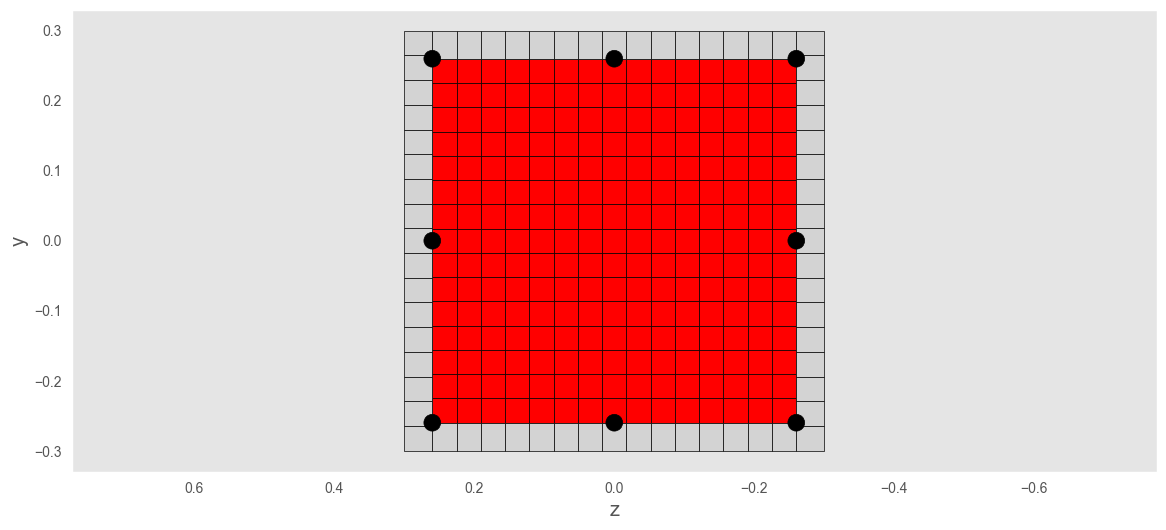

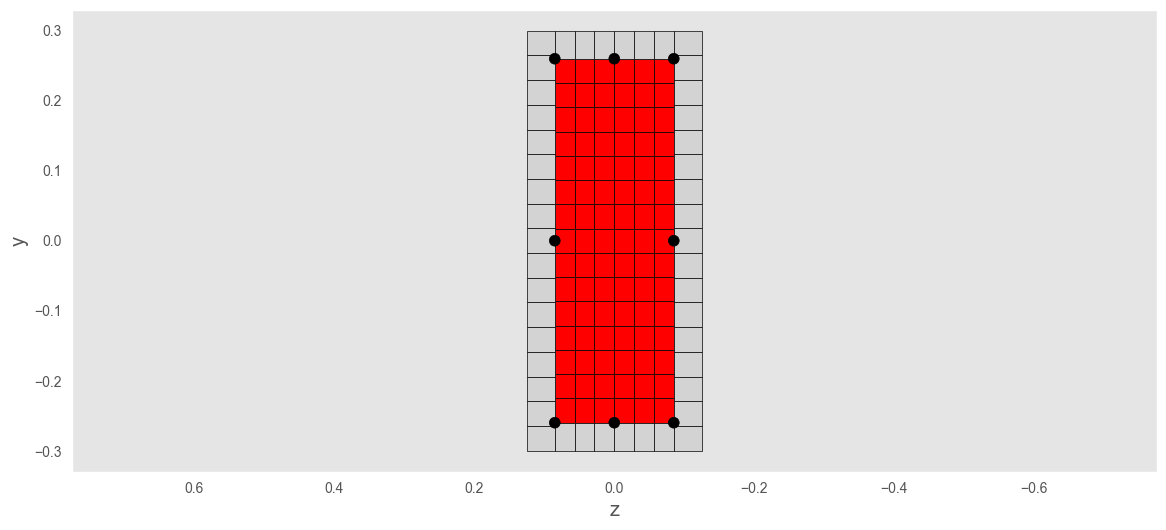

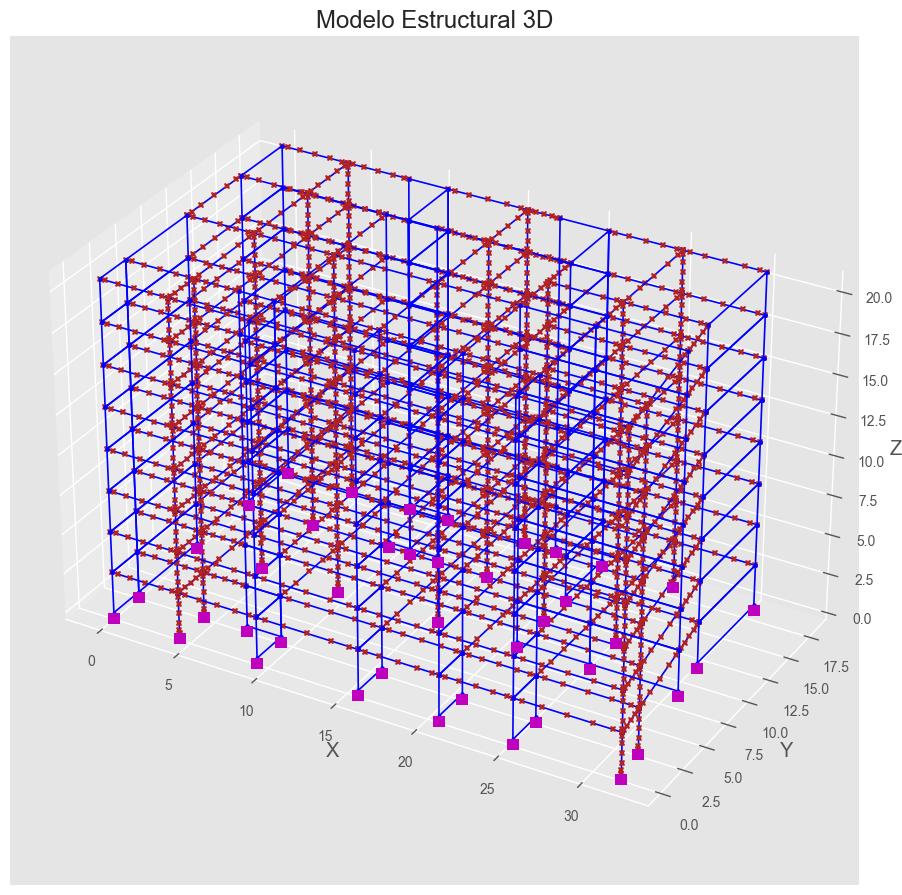

In [69]:
# -------------------------------
# 6.1 Inicializaci√≥n del Modelo
# -------------------------------
ops.wipe()  # Limpiar cualquier modelo existente

# Crear modelo b√°sico 3D con 6 grados de libertad por nodo:
# UX, UY, UZ (traslaciones), RX, RY, RZ (rotaciones)
ops.model('basic', '-ndm', 3, '-ndf', 6)

# Configuraci√≥n de diafragmas r√≠gidos (activado/desactivado)
rigid_diaphragm = True  # Activar para modelar comportamiento de diafragma r√≠gido

# -------------------------------
# 6.2 Definici√≥n de Materiales
# -------------------------------

# Material para cortante en muros (el√°stico)
ops.uniaxialMaterial('Elastic', 3, G)  # G: M√≥dulo de cortante (Pa)

# Concreto confinado (n√∫cleo de columnas)
ops.uniaxialMaterial('Concrete02', 4,
    fpc1,    # Resistencia m√°xima (Pa)
    epsc01,  # Deformaci√≥n en resistencia m√°xima
    fpcu1,   # Resistencia √∫ltima (Pa)
    epsU1,   # Deformaci√≥n √∫ltima
    lambda1, # Par√°metro de tensi√≥n
    ft1,     # Resistencia a tensi√≥n (Pa)
    Ets      # Pendiente de ablandamiento
)

# Concreto no confinado (recubrimiento)
ops.uniaxialMaterial('Concrete02', 5,
    fpc2,    # Resistencia m√°xima (Pa)
    epsc02,  # Deformaci√≥n en resistencia m√°xima
    fpcu2,   # Resistencia √∫ltima (Pa)
    epsU2,   # Deformaci√≥n √∫ltima
    lambda1, # Par√°metro de tensi√≥n (mismo que confinado)
    ft2,     # Resistencia a tensi√≥n (Pa)
    Ets      # Pendiente de ablandamiento (mismo que confinado)
)

# Acero de refuerzo (barras longitudinales y transversales)
ops.uniaxialMaterial('Steel02', 6,
    fy,      # Esfuerzo de fluencia (Pa)
    Es,      # M√≥dulo de elasticidad (Pa)
    0.01,    # Raz√≥n de endurecimiento
    18,      # Par√°metro de transici√≥n
    0.925,   # Par√°metro de tensi√≥n
    0.15     # Par√°metro de tolerancia
)

# -------------------------------
# 6.3 Creaci√≥n de Secciones
# -------------------------------
# Generar objetos seccionales para columnas y vigas
columnas = [SeccionRectangular(col[0], col[1]) for col in sec_columnas]
vigas = [SeccionRectangular(vig[0], vig[1]) for vig in sec_vigas]

structure_model = StructureModel(num_columnas, num_vigas, columnas, vigas, G, cover)
structure_model.create_structure()

# -------------------------------
# 6.4 Creaci√≥n de Nodos
# -------------------------------
for nodo in nodes:
    ops.node(int(nodo[0]),  # Tag del nodo
             nodo[1],       # Coordenada X (m)
             nodo[2],       # Coordenada Y (m)
             nodo[3])       # Coordenada Z (m)

# -------------------------------
# 6.5 Diafragmas R√≠gidos
# -------------------------------
if rigid_diaphragm:
    dir_diaphragm = 3  # Eje perpendicular al plano del diafragma (Z)

    for d in diafragmas:
        # Crear nodo maestro del diafragma
        ops.node(int(d[0]), d[1], d[2], d[3])

        # Restringir grados de libertad (solo permite traslaci√≥n en XY)
        ops.fix(int(d[0]), 0, 0, 1, 1, 1, 0)

        # Identificar nodos pertenecientes al mismo nivel
        nodes_at_level = [int(nodo[0]) for nodo in nodes if nodo[3] == d[3]]

        # Crear diafragma r√≠gido
        ops.rigidDiaphragm(dir_diaphragm,
                          int(d[0]),  # Nodo maestro
                          *nodes_at_level)  # Nodos esclavos

# -------------------------------
# 6.6 Restricciones en la Base
# -------------------------------
ops.fixZ(0.0,        # Elevaci√≥n Z=0
         1, 1, 1,    # Restringir traslaciones UX, UY, UZ
         1, 1, 1,    # Restringir rotaciones RX, RY, RZ
         '-tol', 1e-6)  # Tolerancia para identificar nodos

# -------------------------------
# 6.7 Transformaciones Geom√©tricas
# -------------------------------
# PDelta: Considera efectos geom√©tricos no lineales
ops.geomTransf('PDelta', 1, 1, 0, 0)  # Para columnas

# Linear: Transformaci√≥n lineal est√°ndar
ops.geomTransf('Linear', 2, 1, -1, 0)  # Para vigas

# -------------------------------
# 6.8 Integraci√≥n de Elementos
# -------------------------------
num_int_points = 7  # Puntos de integraci√≥n Gauss-Lobatto

# Columnas
for i in range(num_columnas):
    ops.beamIntegration('Lobatto',
                       i + 1,          # Tag de integraci√≥n
                       i + 1,          # Tag de secci√≥n
                       num_int_points)  # N√∫mero de puntos

# Vigas
for i in range(num_vigas):
    ops.beamIntegration('Lobatto',
                       i + 1 + num_columnas,  # Tag de integraci√≥n
                       i + 1 + num_columnas,  # Tag de secci√≥n
                       num_int_points)

# -------------------------------
# 6.9 Creaci√≥n de Elementos
# -------------------------------
for elem in elements:
    elem_type = 'forceBeamColumn'  # Tipo de elemento para vigas/columnas

    # Columnas (tipo 1)
    if int(elem[5]) == 1:
        area_columna = elem[3] * elem[4]  # √Årea transversal
        ops.element(elem_type,
                   int(elem[0]),    # Tag del elemento
                   int(elem[1]),    # Nodo I
                   int(elem[2]),    # Nodo J
                   1,               # Transformaci√≥n (PDelta)
                   int(elem[6]),    # Tag de integraci√≥n
                   '-mass',
                   rho * area_columna * m**2)  # Masa distribuida

    # Vigas (tipo 2)
    elif int(elem[5]) == 2:
        area_viga = elem[3] * elem[4]  # √Årea transversal
        ops.element(elem_type,
                   int(elem[0]),
                   int(elem[1]),
                   int(elem[2]),
                   2,               # Transformaci√≥n (Linear)
                   int(elem[6]),
                   '-mass',
                   rho * area_viga * m**2)

    # Muros en X (tipo 3)
    elif int(elem[5]) == 3:
        longitud = abs(nodes[int(elem[1])][1] - nodes[int(elem[2])][1])
        muro_x = Muro(longitud, elem[6])  # Crear objeto muro

        # Obtener propiedades para MVLEM
        nf_x, thk_x, w_list_x, rho_x, conc_x, steel_x = muro_x.prop_muros()

        ops.element('MVLEM_3D',
                   int(elem[0]),    # Tag del elemento
                   int(elem[1]),    # Nodo I
                   int(elem[2]),    # Nodo J
                   int(elem[3]),    # Nodo K
                   int(elem[4]),    # Nodo L
                   nf_x,            # N√∫mero de fibras
                   '-thick', *thk_x,       # Espesores
                   '-width', *w_list_x,    # Anchos
                   '-rho', *rho_x,         # Cuant√≠as
                   '-matConcrete', *conc_x, # Material concreto
                   '-matSteel', *steel_x,  # Material acero
                   '-matShear', 3,         # Material cortante
                   '-Poisson', 0.2,        # Relaci√≥n de Poisson
                   '-Density', rho)        # Densidad

    # Muros en Y (tipo 4)
    elif int(elem[5]) == 4:
        longitud = abs(nodes[int(elem[1])][2] - nodes[int(elem[2])][2])
        muro_y = Muro(longitud, elem[6])

        nf_y, thk_y, w_list_y, rho_y, conc_y, steel_y = muro_y.prop_muros()

        ops.element('MVLEM_3D',
                   int(elem[0]),
                   int(elem[1]),
                   int(elem[2]),
                   int(elem[3]),
                   int(elem[4]),
                   nf_y,
                   '-thick', *thk_y,
                   '-width', *w_list_y,
                   '-rho', *rho_y,
                   '-matConcrete', *conc_y,
                   '-matSteel', *steel_y,
                   '-matShear', 3,
                   '-Poisson', 0.2,
                   '-Density', rho)

# -------------------------------
# 6.10 Visualizaci√≥n del Modelo
# -------------------------------
opsv.plot_model(node_labels=0, element_labels=0, local_axes=False, fig_wi_he=(40, 28))
plt.title("Modelo Estructural 3D")
plt.show()

## 7. An√°lisis Modal y por Gravedad

En esta secci√≥n se realizan dos an√°lisis fundamentales:
1. **An√°lisis Modal**: Calcula las frecuencias naturales y modos de vibraci√≥n
2. **An√°lisis por Gravedad**: Aplica cargas permanentes para obtener el estado de equilibrio inicial

**F√≥rmulas clave**:
- Periodo natural: $T_i = \frac{2\pi}{\sqrt{\lambda_i}}$  
- Peso s√≠smico: $W_{s√≠smico} = (1.0\cdot w_{muerta} + 0.25\cdot w_{viva}) \cdot A_{planta}$


üîπ Periodos naturales de vibraci√≥n:
Modo 1: T = 0.298 seg
Modo 2: T = 0.265 seg
Modo 3: T = 0.233 seg
Modo 4: T = 0.077 seg
Modo 5: T = 0.066 seg
Modo 6: T = 0.057 seg
Modo 7: T = 0.045 seg
Modo 8: T = 0.043 seg
Modo 9: T = 0.042 seg
Modo 10: T = 0.040 seg
Modo 11: T = 0.039 seg
Modo 12: T = 0.039 seg
Modo 13: T = 0.038 seg
Modo 14: T = 0.038 seg
Modo 15: T = 0.036 seg
Modo 16: T = 0.036 seg
Modo 17: T = 0.036 seg
Modo 18: T = 0.035 seg
Modo 19: T = 0.034 seg
Modo 20: T = 0.033 seg
Modo 21: T = 0.033 seg
Modo 22: T = 0.032 seg
Modo 23: T = 0.031 seg
Modo 24: T = 0.030 seg


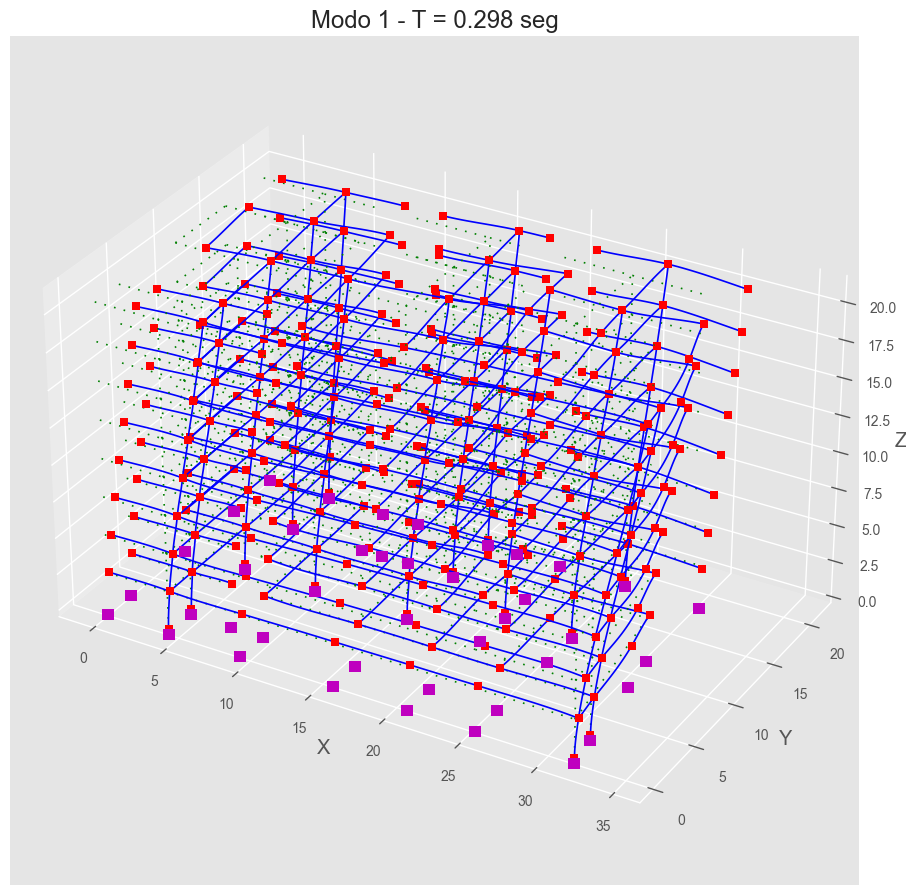

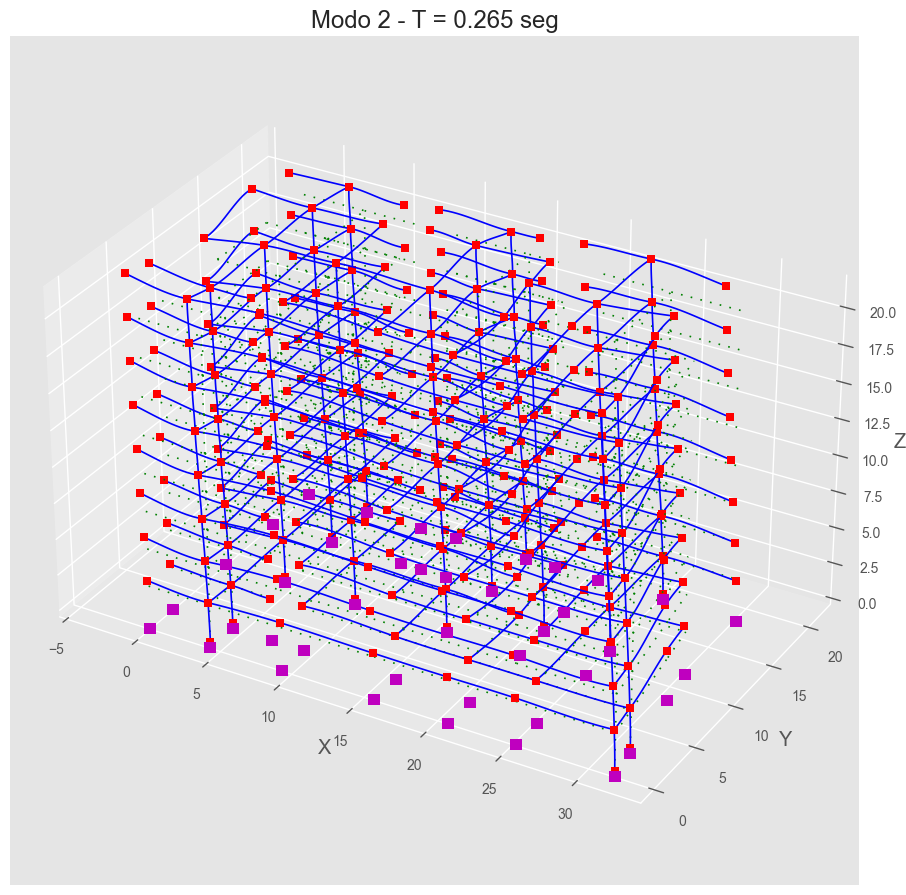

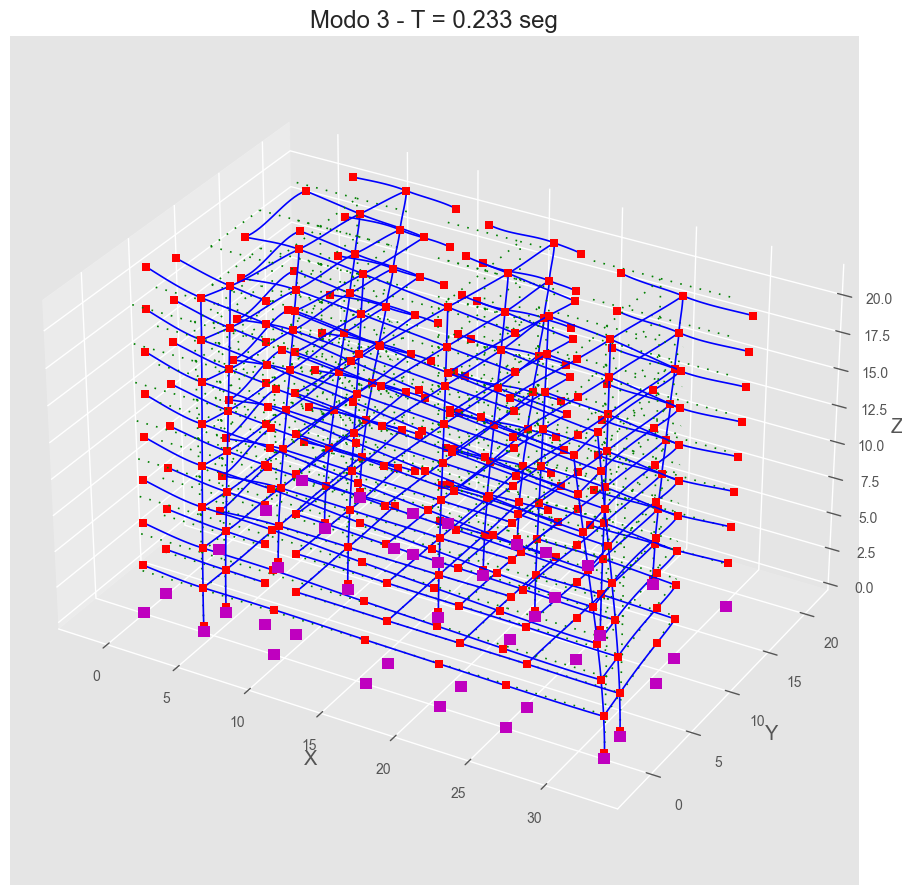

vfo: Calculated modal periods...

Mode       Period (sec)
 1.         0.2976528 
 2.         0.26494925
 3.         0.23284524
 

************************************************************************

>>vfo: Time to calculate and save modeshapes (secs) =  0.28125  <<
************************************************************************



0

In [70]:
# -------------------------------
# 7.1 Definici√≥n de Cargas
# -------------------------------

# Cargas unitarias (kg/m¬≤)
wLive = 250 * kg/m**2      # Carga viva
wLosa = 300 * kg/m**2      # Peso losa
wAcab = 100 * kg/m**2      # Acabados
wTabi = 150 * kg/m**2      # Tabiquer√≠a

# Combinaci√≥n de cargas (100% permanente + 25% viva)
wTotal = 1.0*(wLosa + wAcab + wTabi) + 0.25*wLive

# Carga total por nivel (N)
Carga = wTotal * aPlanta * m**2

# -------------------------------
# 7.2 Asignaci√≥n de Masas
# -------------------------------
for ni in nodes:
    # Calcular masa nodal proporcional al factor de masa (ni[4])
    masa_nodal = ni[4] * Carga / ((len(nodes)-len(rest_node))/nz)

    # Asignar masa en direcciones X e Y (despreciable en Z)
    ops.mass(int(ni[0]), masa_nodal, masa_nodal, 0.0)

# -------------------------------
# 7.3 An√°lisis Modal
# -------------------------------
Nmodes = 3 * nz  # N√∫mero de modos a calcular (3 por piso)

# Calcular autovalores
vals = ops.eigen(Nmodes)

# Calcular periodos naturales
Tmodes = [2*np.pi/np.sqrt(val) for val in vals]

# Imprimir resultados
print("\nüîπ Periodos naturales de vibraci√≥n:")
for i, T in enumerate(Tmodes, 1):
    print(f"Modo {i}: T = {T:.3f} seg")

# Visualizaci√≥n de modos
for i in range(3):
    opsv.plot_mode_shape(i+1, fig_wi_he=(40, 28))
    plt.title(f'Modo {i+1} - T = {Tmodes[i]:.3f} seg')
plt.show()

# Guardar resultados
vfo.createODB('No_Linear_Building', "Gravity", Nmodes=3)

# Configurar patr√≥n de carga
ops.timeSeries('Linear', 1)
ops.pattern('Plain', 1, 1)

# -------------------------------
# 7.4.1 Cargas en Elementos
# -------------------------------
for ele in elements:
    elem_type = int(ele[5])

    # Columnas (carga axial)
    if elem_type == 1:
        Ac = ele[3] * ele[4]  # √Årea secci√≥n
        ops.eleLoad('-ele', int(ele[0]), '-type',
                   '-beamUniform', 0.0, 0.0, -rho*Ac*g)  # Wx, Wy, Wz

    # Vigas (carga transversal)
    elif elem_type == 2:
        Av = ele[3] * ele[4]
        ops.eleLoad('-ele', int(ele[0]), '-type',
                   '-beamUniform', -rho*Av*g, 0.0, 0.0)

    # Muros en X
    elif elem_type == 3:
        L = abs(nodes[int(ele[1])][1] - nodes[int(ele[2])][1])
        t = ele[6]
        carga_muro = 0.25 * dz * L * t * rho * g

        # Aplicar a 4 nodos del muro
        for n in [int(ele[i]) for i in range(1,5)]:
            ops.load(n, 0., 0., -carga_muro, 0., 0., 0.)

    # Muros en Y
    elif elem_type == 4:
        L = abs(nodes[int(ele[1])][2] - nodes[int(ele[2])][2])
        t = ele[6]
        carga_muro = 0.25 * dz * L * t * rho * g

        for n in [int(ele[i]) for i in range(1,5)]:
            ops.load(n, 0., 0., -carga_muro, 0., 0., 0.)
    else:
        print("Error!. Es un elemento no definido!")

# -------------------------------
# 7.4.2 Cargas Nodales
# -------------------------------
for ni in nodes:
    if float(ni[3]) > 0:  # Solo nodos sobre la base
        carga_nodal = ni[4] * Carga * g / ((len(nodes)-len(rest_node))/nz)
        ops.load(int(ni[0]), 0.0, 0.0, -carga_nodal, 0.0, 0.0, 0.0)

# -------------------------------
# 7.5.1 Configuraci√≥n del An√°lisis
# -------------------------------
Tol = 1.0e-8  # Tolerancia de convergencia

# Configuraci√≥n para diafragmas r√≠gidos
constraintsType = "Transformation" if rigid_diaphragm else "Plain"

ops.constraints(constraintsType)
ops.numberer('RCM')            # Renumeraci√≥n √≥ptima
ops.system('BandGeneral')      # Solucionador
ops.test('EnergyIncr', Tol, 6) # Prueba de convergencia
ops.algorithm('Newton')        # Algoritmo Newton-Raphson

# -------------------------------
# 7.5.2 Aplicaci√≥n Gradual de Cargas
# -------------------------------
NstepGravity = 10  # N√∫mero de pasos
DGravity = 1.0 / NstepGravity  # first load increment
ops.integrator('LoadControl', DGravity)
ops.analysis('Static')
ops.analyze(NstepGravity)  # apply gravity

## 8. An√°lisis Din√°mico No Lineal

Este m√≥dulo realiza el an√°lisis din√°mico temporal del edificio sometido a un acelerograma.

**Proceso completo:**
1. Configuraci√≥n del an√°lisis din√°mico
2. Definici√≥n de amortiguamiento de Rayleigh
3. Procesamiento del registro s√≠smico
4. Ejecuci√≥n del an√°lisis paso a paso
5. Estrategias de recuperaci√≥n ante no convergencia

#### **Amortiguamiento de Rayleigh**
F√≥rmula: $\xi = \alpha_M M + \beta_K K$

Donde:
- $\alpha_M = \xi \frac{2\omega_i\omega_j}{\omega_i + \omega_j}$
- $\beta_K = \xi \frac{2}{\omega_i + \omega_j}$


In [71]:
# Configuraci√≥n inicial mejorada para IDA
ops.loadConst('-time', 0.0)
ops.wipeAnalysis()
vfo.createODB('No_Linear_Building', "IDA_Analysis")

print("\nüî• INICIANDO AN√ÅLISIS DIN√ÅMICO NO LINEAL (IDA) üî•")
print("==============================================")

# Par√°metros generales del an√°lisis s√≠smico
GMdirection = 1
DtAnalysis = 0.02
TmaxAnalysis = 30.0

# Escalamiento s√≠smico (factores para IDA)
IM_min = 0.1  # g
IM_max = 8.0   # g
IM_step = 0.1
GMfactors = np.arange(IM_min, IM_max + IM_step, IM_step)

# Direcci√≥n del registro s√≠smico y archivo
inFile = "elCentro.AT2"
outFile = "elCentro.g3"
dt, npts = ReadRecord(inFile, outFile)

# Loop de an√°lisis para cada factor de escala
for i, GMfact in enumerate(GMfactors):
    print(f"\n‚ö° Ejecutando IDA con factor de escala: {GMfact:.1f} ({i+1}/{len(GMfactors)})")
    
    # Reinicio de condiciones iniciales
    ops.wipeAnalysis()
    ops.loadConst('-time', 0.0)

    # Sistema de ecuaciones y solucionadores
    ops.constraints("Transformation")
    ops.numberer("RCM")
    ops.system("BandGeneral")

    # Par√°metros de prueba de convergencia
    TolDynamic = 1e-6
    maxNumIterDynamic = 50
    printFlagDynamic = 0
    ops.test("EnergyIncr", TolDynamic, maxNumIterDynamic, printFlagDynamic)

    # Algoritmos de soluci√≥n
    algorithms = [
        {"name": "ModifiedNewton", "args": None, "desc": "Newton modificado (eficiente)"},
        {"name": "Newton", "args": "-initial", "desc": "Newton con tangente inicial"},
        {"name": "Broyden", "args": 8, "desc": "Broyden (8 iteraciones)"},
        {"name": "NewtonLineSearch", "args": "0.8", "desc": "Newton con b√∫squeda de l√≠nea (0.8)"},
        {"name": "KrylovNewton", "args": None, "desc": "Krylov-Newton (para sistemas grandes)"}
    ]

    current_algorithm_idx = 0
    current_algo = algorithms[current_algorithm_idx]
    print(f"üîÑ Algoritmo inicial: {current_algo['name']} - {current_algo['desc']}")
    ops.algorithm(current_algo["name"], current_algo["args"] if current_algo["args"] else "")

    # Integrador e integraci√≥n temporal
    ops.integrator("Newmark", 0.5, 0.25)
    ops.analysis("Transient")

    # Amortiguamiento Rayleigh
    xDamp = 0.02
    ops.rayleigh(xDamp*0.1, 0.0, 0.0, xDamp*0.9)

    # Registro s√≠smico escalado
    IDloadTag = i + 100
    GMfatt = g * GMfact
    ops.timeSeries('Path', IDloadTag, '-dt', dt, '-filePath', outFile, '-factor', GMfatt)
    ops.pattern("UniformExcitation", IDloadTag, GMdirection, "-accel", IDloadTag)

    # Grabadores para cada escalamiento (sin closeOnWrite)
    tagDiap = [int(Nd[0]) for Nd in diafragmas]
    recorder_file = f'Diafragmas_IDA_UX_{GMfact:.1f}.txt'
    recorder_tag = ops.recorder('Node', '-file', recorder_file, '-node', *tagDiap, '-dof', 1, 'disp')

    start_time = time.time()
    Nsteps = int(TmaxAnalysis / DtAnalysis)
    controlTime = 0.0
    successful_steps = 0
    failed_steps = 0

    # Configuraci√≥n de la barra de progreso
    with tqdm(total=TmaxAnalysis, desc="Progreso del an√°lisis", unit="s", 
             bar_format="{l_bar}{bar}| {n:.1f}/{total_fmt} [{elapsed}<{remaining}]") as progress_bar:

        while controlTime < TmaxAnalysis:
            ok = ops.analyze(1, DtAnalysis)

            if ok == 0:
                successful_steps += 1
                controlTime = ops.getTime()
                progress_bar.update(DtAnalysis)
                
                if current_algorithm_idx > 0:
                    current_algorithm_idx = 0
                    current_algo = algorithms[current_algorithm_idx]
                    ops.algorithm(current_algo["name"], current_algo["args"] if current_algo["args"] else "")
                    print(f"‚Ü©Ô∏è Volviendo al algoritmo principal: {current_algo['name']}")
            else:
                failed_steps += 1
                progress_bar.set_postfix_str(f"‚ùå Fallo en convergencia (intentos: {failed_steps})")

                current_algorithm_idx += 1

                if current_algorithm_idx < len(algorithms):
                    current_algo = algorithms[current_algorithm_idx]
                    ops.algorithm(current_algo["name"], current_algo["args"] if current_algo["args"] else "")
                    print(f"üîÑ Cambiando a algoritmo: {current_algo['name']} - {current_algo['desc']}")
                else:
                    reduced_dt = DtAnalysis / 2.0
                    progress_bar.write(f"‚ö†Ô∏è Todos los algoritmos fallaron. Probando con dt reducido: {reduced_dt:.4f}s")

                    ok = ops.analyze(1, reduced_dt)
                    if ok == 0:
                        controlTime = ops.getTime()
                        successful_steps += 1
                        progress_bar.update(reduced_dt)
                        print(f"‚úÖ Paso exitoso con dt reducido (t={controlTime:.2f}s)")
                    else:
                        progress_bar.write("üí• An√°lisis no puede continuar. Deteniendo...")
                        break

                    current_algorithm_idx = 0
                    current_algo = algorithms[current_algorithm_idx]
                    ops.algorithm(current_algo["name"], current_algo["args"] if current_algo["args"] else "")

    # Cierre adecuado del recorder usando su tag
    ops.remove('recorder', recorder_tag)
    print(f"‚úîÔ∏è Recorder {recorder_tag} cerrado - Archivo: {recorder_file}")

    print(f"‚úîÔ∏è Archivo {recorder_file} cerrado correctamente")

    end_time = time.time()
    elapsed_time = end_time - start_time
    hours = int(elapsed_time // 3600)
    minutes = int((elapsed_time % 3600) // 60)
    seconds = int(elapsed_time % 60)

    print("\nüìù RESUMEN ANALISIS")
    print("============================")
    print(f"Factor de escala: {GMfact:.1f}")
    print(f"Tiempo simulado: {controlTime:.2f}s de {TmaxAnalysis}s")
    print(f"Pasos exitosos: {successful_steps}")
    print(f"Pasos fallidos: {failed_steps}")
    print(f"Tasa de √©xito: {successful_steps/(successful_steps+failed_steps)*100:.1f}%")
    print(f"Tiempo de ejecuci√≥n: {hours}h {minutes}m {seconds}s\n")


üî• INICIANDO AN√ÅLISIS DIN√ÅMICO NO LINEAL (IDA) üî•

‚ö° Ejecutando IDA con factor de escala: 0.1 (1/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 30.0/30.0 [07:01<00:00]c:\Users\doxme\.conda\envs\latest_openseespy\Lib\site-packages\tqdm\std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [07:01<00:00]


‚úîÔ∏è Recorder 100 cerrado - Archivo: Diafragmas_IDA_UX_0.1.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_0.1.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 0.1
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 0
Tasa de √©xito: 100.0%
Tiempo de ejecuci√≥n: 0h 7m 1s


‚ö° Ejecutando IDA con factor de escala: 0.2 (2/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [07:36<00:00]


‚úîÔ∏è Recorder 101 cerrado - Archivo: Diafragmas_IDA_UX_0.2.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_0.2.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 0.2
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 0
Tasa de √©xito: 100.0%
Tiempo de ejecuci√≥n: 0h 7m 36s


‚ö° Ejecutando IDA con factor de escala: 0.3 (3/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [07:55<00:00]


‚úîÔ∏è Recorder 102 cerrado - Archivo: Diafragmas_IDA_UX_0.3.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_0.3.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 0.3
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 0
Tasa de √©xito: 100.0%
Tiempo de ejecuci√≥n: 0h 7m 55s


‚ö° Ejecutando IDA con factor de escala: 0.4 (4/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [08:13<00:00]


‚úîÔ∏è Recorder 103 cerrado - Archivo: Diafragmas_IDA_UX_0.4.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_0.4.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 0.4
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 0
Tasa de √©xito: 100.0%
Tiempo de ejecuci√≥n: 0h 8m 13s


‚ö° Ejecutando IDA con factor de escala: 0.5 (5/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [08:29<00:00]


‚úîÔ∏è Recorder 104 cerrado - Archivo: Diafragmas_IDA_UX_0.5.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_0.5.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 0.5
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 0
Tasa de √©xito: 100.0%
Tiempo de ejecuci√≥n: 0h 8m 29s


‚ö° Ejecutando IDA con factor de escala: 0.6 (6/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [08:43<00:00]


‚úîÔ∏è Recorder 105 cerrado - Archivo: Diafragmas_IDA_UX_0.6.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_0.6.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 0.6
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 0
Tasa de √©xito: 100.0%
Tiempo de ejecuci√≥n: 0h 8m 43s


‚ö° Ejecutando IDA con factor de escala: 0.7 (7/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [08:34<00:00]


‚úîÔ∏è Recorder 106 cerrado - Archivo: Diafragmas_IDA_UX_0.7.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_0.7.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 0.7
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 0
Tasa de √©xito: 100.0%
Tiempo de ejecuci√≥n: 0h 8m 34s


‚ö° Ejecutando IDA con factor de escala: 0.8 (8/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [08:31<00:00]


‚úîÔ∏è Recorder 107 cerrado - Archivo: Diafragmas_IDA_UX_0.8.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_0.8.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 0.8
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 0
Tasa de √©xito: 100.0%
Tiempo de ejecuci√≥n: 0h 8m 31s


‚ö° Ejecutando IDA con factor de escala: 0.9 (9/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [08:47<00:00]


‚úîÔ∏è Recorder 108 cerrado - Archivo: Diafragmas_IDA_UX_0.9.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_0.9.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 0.9
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 0
Tasa de √©xito: 100.0%
Tiempo de ejecuci√≥n: 0h 8m 47s


‚ö° Ejecutando IDA con factor de escala: 1.0 (10/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [08:57<00:00]


‚úîÔ∏è Recorder 109 cerrado - Archivo: Diafragmas_IDA_UX_1.0.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_1.0.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 1.0
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 0
Tasa de √©xito: 100.0%
Tiempo de ejecuci√≥n: 0h 8m 57s


‚ö° Ejecutando IDA con factor de escala: 1.1 (11/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [09:08<00:00]


‚úîÔ∏è Recorder 110 cerrado - Archivo: Diafragmas_IDA_UX_1.1.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_1.1.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 1.1
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 0
Tasa de √©xito: 100.0%
Tiempo de ejecuci√≥n: 0h 9m 8s


‚ö° Ejecutando IDA con factor de escala: 1.2 (12/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [09:18<00:00]


‚úîÔ∏è Recorder 111 cerrado - Archivo: Diafragmas_IDA_UX_1.2.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_1.2.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 1.2
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 0
Tasa de √©xito: 100.0%
Tiempo de ejecuci√≥n: 0h 9m 18s


‚ö° Ejecutando IDA con factor de escala: 1.3 (13/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [09:30<00:00]


‚úîÔ∏è Recorder 112 cerrado - Archivo: Diafragmas_IDA_UX_1.3.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_1.3.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 1.3
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 0
Tasa de √©xito: 100.0%
Tiempo de ejecuci√≥n: 0h 9m 30s


‚ö° Ejecutando IDA con factor de escala: 1.4 (14/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [09:42<00:00]


‚úîÔ∏è Recorder 113 cerrado - Archivo: Diafragmas_IDA_UX_1.4.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_1.4.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 1.4
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 0
Tasa de √©xito: 100.0%
Tiempo de ejecuci√≥n: 0h 9m 42s


‚ö° Ejecutando IDA con factor de escala: 1.5 (15/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [09:53<00:00]


‚úîÔ∏è Recorder 114 cerrado - Archivo: Diafragmas_IDA_UX_1.5.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_1.5.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 1.5
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 0
Tasa de √©xito: 100.0%
Tiempo de ejecuci√≥n: 0h 9m 53s


‚ö° Ejecutando IDA con factor de escala: 1.6 (16/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [10:06<00:00]


‚úîÔ∏è Recorder 115 cerrado - Archivo: Diafragmas_IDA_UX_1.6.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_1.6.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 1.6
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 0
Tasa de √©xito: 100.0%
Tiempo de ejecuci√≥n: 0h 10m 6s


‚ö° Ejecutando IDA con factor de escala: 1.7 (17/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [10:16<00:00]


‚úîÔ∏è Recorder 116 cerrado - Archivo: Diafragmas_IDA_UX_1.7.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_1.7.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 1.7
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 0
Tasa de √©xito: 100.0%
Tiempo de ejecuci√≥n: 0h 10m 16s


‚ö° Ejecutando IDA con factor de escala: 1.8 (18/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [10:25<00:00]


‚úîÔ∏è Recorder 117 cerrado - Archivo: Diafragmas_IDA_UX_1.8.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_1.8.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 1.8
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 0
Tasa de √©xito: 100.0%
Tiempo de ejecuci√≥n: 0h 10m 25s


‚ö° Ejecutando IDA con factor de escala: 1.9 (19/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [10:37<00:00]


‚úîÔ∏è Recorder 118 cerrado - Archivo: Diafragmas_IDA_UX_1.9.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_1.9.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 1.9
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 0
Tasa de √©xito: 100.0%
Tiempo de ejecuci√≥n: 0h 10m 37s


‚ö° Ejecutando IDA con factor de escala: 2.0 (20/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [10:50<00:00]


‚úîÔ∏è Recorder 119 cerrado - Archivo: Diafragmas_IDA_UX_2.0.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_2.0.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 2.0
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 0
Tasa de √©xito: 100.0%
Tiempo de ejecuci√≥n: 0h 10m 50s


‚ö° Ejecutando IDA con factor de escala: 2.1 (21/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [11:00<00:00]


‚úîÔ∏è Recorder 120 cerrado - Archivo: Diafragmas_IDA_UX_2.1.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_2.1.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 2.1
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 0
Tasa de √©xito: 100.0%
Tiempo de ejecuci√≥n: 0h 11m 0s


‚ö° Ejecutando IDA con factor de escala: 2.2 (22/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [11:10<00:00]


‚úîÔ∏è Recorder 121 cerrado - Archivo: Diafragmas_IDA_UX_2.2.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_2.2.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 2.2
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 0
Tasa de √©xito: 100.0%
Tiempo de ejecuci√≥n: 0h 11m 10s


‚ö° Ejecutando IDA con factor de escala: 2.3 (23/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [11:18<00:00]


‚úîÔ∏è Recorder 122 cerrado - Archivo: Diafragmas_IDA_UX_2.3.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_2.3.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 2.3
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 0
Tasa de √©xito: 100.0%
Tiempo de ejecuci√≥n: 0h 11m 18s


‚ö° Ejecutando IDA con factor de escala: 2.4 (24/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [11:30<00:00]


‚úîÔ∏è Recorder 123 cerrado - Archivo: Diafragmas_IDA_UX_2.4.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_2.4.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 2.4
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 0
Tasa de √©xito: 100.0%
Tiempo de ejecuci√≥n: 0h 11m 30s


‚ö° Ejecutando IDA con factor de escala: 2.5 (25/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [11:37<00:00]


‚úîÔ∏è Recorder 124 cerrado - Archivo: Diafragmas_IDA_UX_2.5.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_2.5.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 2.5
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 0
Tasa de √©xito: 100.0%
Tiempo de ejecuci√≥n: 0h 11m 37s


‚ö° Ejecutando IDA con factor de escala: 2.6 (26/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [11:52<00:00]


‚úîÔ∏è Recorder 125 cerrado - Archivo: Diafragmas_IDA_UX_2.6.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_2.6.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 2.6
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 0
Tasa de √©xito: 100.0%
Tiempo de ejecuci√≥n: 0h 11m 52s


‚ö° Ejecutando IDA con factor de escala: 2.7 (27/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [12:00<00:00]


‚úîÔ∏è Recorder 126 cerrado - Archivo: Diafragmas_IDA_UX_2.7.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_2.7.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 2.7
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 0
Tasa de √©xito: 100.0%
Tiempo de ejecuci√≥n: 0h 12m 0s


‚ö° Ejecutando IDA con factor de escala: 2.8 (28/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [12:06<00:00]


‚úîÔ∏è Recorder 127 cerrado - Archivo: Diafragmas_IDA_UX_2.8.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_2.8.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 2.8
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 0
Tasa de √©xito: 100.0%
Tiempo de ejecuci√≥n: 0h 12m 6s


‚ö° Ejecutando IDA con factor de escala: 2.9 (29/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [12:16<00:00]


‚úîÔ∏è Recorder 128 cerrado - Archivo: Diafragmas_IDA_UX_2.9.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_2.9.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 2.9
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 0
Tasa de √©xito: 100.0%
Tiempo de ejecuci√≥n: 0h 12m 16s


‚ö° Ejecutando IDA con factor de escala: 3.0 (30/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [12:24<00:00]


‚úîÔ∏è Recorder 129 cerrado - Archivo: Diafragmas_IDA_UX_3.0.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_3.0.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 3.0
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 0
Tasa de √©xito: 100.0%
Tiempo de ejecuci√≥n: 0h 12m 24s


‚ö° Ejecutando IDA con factor de escala: 3.1 (31/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [12:34<00:00]


‚úîÔ∏è Recorder 130 cerrado - Archivo: Diafragmas_IDA_UX_3.1.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_3.1.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 3.1
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 0
Tasa de √©xito: 100.0%
Tiempo de ejecuci√≥n: 0h 12m 34s


‚ö° Ejecutando IDA con factor de escala: 3.2 (32/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [12:42<00:00]


‚úîÔ∏è Recorder 131 cerrado - Archivo: Diafragmas_IDA_UX_3.2.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_3.2.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 3.2
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 0
Tasa de √©xito: 100.0%
Tiempo de ejecuci√≥n: 0h 12m 42s


‚ö° Ejecutando IDA con factor de escala: 3.3 (33/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [12:51<00:00]


‚úîÔ∏è Recorder 132 cerrado - Archivo: Diafragmas_IDA_UX_3.3.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_3.3.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 3.3
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 0
Tasa de √©xito: 100.0%
Tiempo de ejecuci√≥n: 0h 12m 51s


‚ö° Ejecutando IDA con factor de escala: 3.4 (34/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [12:58<00:00]


‚úîÔ∏è Recorder 133 cerrado - Archivo: Diafragmas_IDA_UX_3.4.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_3.4.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 3.4
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 0
Tasa de √©xito: 100.0%
Tiempo de ejecuci√≥n: 0h 12m 58s


‚ö° Ejecutando IDA con factor de escala: 3.5 (35/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [13:06<00:00]


‚úîÔ∏è Recorder 134 cerrado - Archivo: Diafragmas_IDA_UX_3.5.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_3.5.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 3.5
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 0
Tasa de √©xito: 100.0%
Tiempo de ejecuci√≥n: 0h 13m 6s


‚ö° Ejecutando IDA con factor de escala: 3.6 (36/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [13:13<00:00]


‚úîÔ∏è Recorder 135 cerrado - Archivo: Diafragmas_IDA_UX_3.6.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_3.6.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 3.6
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 0
Tasa de √©xito: 100.0%
Tiempo de ejecuci√≥n: 0h 13m 13s


‚ö° Ejecutando IDA con factor de escala: 3.7 (37/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis:   8%|‚ñä         | 2.4/30.0 [01:07<17:33]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 0.00542405 (max: 1e-06) 	Norm deltaX: 4.12013e-06, Norm deltaR: 7770.25
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.46
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.5/30.0 [01:11<39:31]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [13:22<00:00]


‚úîÔ∏è Recorder 136 cerrado - Archivo: Diafragmas_IDA_UX_3.7.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_3.7.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 3.7
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 1
Tasa de √©xito: 99.9%
Tiempo de ejecuci√≥n: 0h 13m 22s


‚ö° Ejecutando IDA con factor de escala: 3.8 (38/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [13:29<00:00]


‚úîÔ∏è Recorder 137 cerrado - Archivo: Diafragmas_IDA_UX_3.8.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_3.8.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 3.8
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 0
Tasa de √©xito: 100.0%
Tiempo de ejecuci√≥n: 0h 13m 29s


‚ö° Ejecutando IDA con factor de escala: 3.9 (39/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [13:35<00:00]


‚úîÔ∏è Recorder 138 cerrado - Archivo: Diafragmas_IDA_UX_3.9.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_3.9.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 3.9
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 0
Tasa de √©xito: 100.0%
Tiempo de ejecuci√≥n: 0h 13m 35s


‚ö° Ejecutando IDA con factor de escala: 4.0 (40/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [13:39<00:00]


‚úîÔ∏è Recorder 139 cerrado - Archivo: Diafragmas_IDA_UX_4.0.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_4.0.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 4.0
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 0
Tasa de √©xito: 100.0%
Tiempo de ejecuci√≥n: 0h 13m 39s


‚ö° Ejecutando IDA con factor de escala: 4.1 (41/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [01:04<18:52]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 4.54481e-05 (max: 1e-06) 	Norm deltaX: 4.43913e-07, Norm deltaR: 592.313
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.3
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [01:07<33:02]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [13:52<00:00]


‚úîÔ∏è Recorder 140 cerrado - Archivo: Diafragmas_IDA_UX_4.1.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_4.1.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 4.1
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 1
Tasa de √©xito: 99.9%
Tiempo de ejecuci√≥n: 0h 13m 52s


‚ö° Ejecutando IDA con factor de escala: 4.2 (42/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [13:54<00:00]


‚úîÔ∏è Recorder 141 cerrado - Archivo: Diafragmas_IDA_UX_4.2.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_4.2.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 4.2
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 0
Tasa de √©xito: 100.0%
Tiempo de ejecuci√≥n: 0h 13m 54s


‚ö° Ejecutando IDA con factor de escala: 4.3 (43/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [00:56<14:18]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 0.128548 (max: 1e-06) 	Norm deltaX: 3.1926e-05, Norm deltaR: 9654.17
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.1
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [00:59<33:55]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 98(dW: << 432196, dW0: 1.78715e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.12
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:00<33:55]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial


Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:03<39:32]

‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [14:04<00:00]


‚úîÔ∏è Recorder 142 cerrado - Archivo: Diafragmas_IDA_UX_4.3.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_4.3.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 4.3
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 2
Tasa de √©xito: 99.9%
Tiempo de ejecuci√≥n: 0h 14m 4s


‚ö° Ejecutando IDA con factor de escala: 4.4 (44/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [00:57<14:12]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 39.0997 (max: 1e-06) 	Norm deltaX: 0.000443779, Norm deltaR: 534880
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.1
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:02<46:40]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [14:08<00:00]


‚úîÔ∏è Recorder 143 cerrado - Archivo: Diafragmas_IDA_UX_4.4.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_4.4.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 4.4
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 1
Tasa de √©xito: 99.9%
Tiempo de ejecuci√≥n: 0h 14m 8s


‚ö° Ejecutando IDA con factor de escala: 4.5 (45/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [00:58<20:37]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 280(dW: << 0.112144, dW0: 3.48195e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.12
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:03<20:37]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 281(dW: << 0.00744365, dW0: 68.2106)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.12
OpenSees > analyze failed, returned: -3 error flag
P

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)


Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:05<42:24]

‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [14:15<00:00]


‚úîÔ∏è Recorder 144 cerrado - Archivo: Diafragmas_IDA_UX_4.5.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_4.5.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 4.5
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 2
Tasa de √©xito: 99.9%
Tiempo de ejecuci√≥n: 0h 14m 15s


‚ö° Ejecutando IDA con factor de escala: 4.6 (46/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [00:57<14:06]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 342(dW: << -0.0256976, dW0: 1.03159)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.08
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [00:58<14:06]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 342(dW: << 0.0235996, dW0: 7.96685e+08)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.08
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [00:59<14:06]WARNING: CTestEnergyIncr::test() - failed to converge 


üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)


after: 10 iterations
 current EnergyIncr: 9.48237e-05 (max: 1e-06) 	Norm deltaX: 7.98425e-07, Norm deltaR: 380.273
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:00<30:24]

‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   7%|‚ñã         | 2.2/30.0 [01:07<22:48]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 0.000509729 (max: 1e-06) 	Norm deltaX: 1.30353e-06, Norm deltaR: 4843.18
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.26
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [01:10<40:18]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [14:20<00:00]


‚úîÔ∏è Recorder 145 cerrado - Archivo: Diafragmas_IDA_UX_4.6.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_4.6.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 4.6
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 3
Tasa de √©xito: 99.8%
Tiempo de ejecuci√≥n: 0h 14m 20s


‚ö° Ejecutando IDA con factor de escala: 4.7 (47/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:01<20:19]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 27768.8 (max: 1e-06) 	Norm deltaX: 0.0208881, Norm deltaR: 5.09702e+06
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.12
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:09<20:19]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 207(dW: << 3.06491, dW0: 4.71784)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.12
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:10<20:19]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)


Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:12<1:06:18]

‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   7%|‚ñã         | 2.2/30.0 [01:16<33:32]  WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 5.64223e-06 (max: 1e-06) 	Norm deltaX: 1.13584e-07, Norm deltaR: 580.655
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.24
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.2/30.0 [01:20<49:38]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [14:38<00:00]


‚úîÔ∏è Recorder 146 cerrado - Archivo: Diafragmas_IDA_UX_4.7.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_4.7.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 4.7
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 3
Tasa de √©xito: 99.8%
Tiempo de ejecuci√≥n: 0h 14m 38s


‚ö° Ejecutando IDA con factor de escala: 4.8 (48/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:00<15:52]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 0.00078751 (max: 1e-06) 	Norm deltaX: 2.44647e-06, Norm deltaR: 934.304
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.12
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:02<15:52]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 141(dW: << 2.02534, dW0: 2.16094)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 250(dW: << 2.90912, dW0: 4.60752)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorith

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)


Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:04<29:07]

‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   7%|‚ñã         | 2.2/30.0 [01:08<22:03]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 0.00472373 (max: 1e-06) 	Norm deltaX: 4.43551e-06, Norm deltaR: 14321.7
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.26
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [01:12<42:28]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


after: 50 iterations
 current EnergyIncr: 2.846e-05 (max: 1e-06) 	Norm deltaX: 3.39178e-07, Norm deltaR: 1065.9
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.28
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [01:16<53:47]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [14:34<00:00]


‚úîÔ∏è Recorder 147 cerrado - Archivo: Diafragmas_IDA_UX_4.8.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_4.8.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 4.8
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 4
Tasa de √©xito: 99.7%
Tiempo de ejecuci√≥n: 0h 14m 34s


‚ö° Ejecutando IDA con factor de escala: 4.9 (49/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:00<15:47]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 25.7684 (max: 1e-06) 	Norm deltaX: 0.00047761, Norm deltaR: 171830
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.1
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:05<45:19]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


after: 50 iterations
 current EnergyIncr: 2.53834 (max: 1e-06) 	Norm deltaX: 0.000124919, Norm deltaR: 62771.5
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.12
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:10<1:05:42]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


after: 50 iterations
 current EnergyIncr: 346.379 (max: 1e-06) 	Norm deltaX: 0.00197816, Norm deltaR: 817674
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.14
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:15<1:24:57]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   7%|‚ñã         | 2.2/30.0 [01:20<34:04]  WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 1.26074 (max: 1e-06) 	Norm deltaX: 5.51064e-05, Norm deltaR: 325457
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.26
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [01:24<55:38]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


after: 50 iterations
 current EnergyIncr: 18.6954 (max: 1e-06) 	Norm deltaX: 0.00026214, Norm deltaR: 1.13735e+06
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.28
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [01:28<1:07:03]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


after: 50 iterations
 current EnergyIncr: 0.0212626 (max: 1e-06) 	Norm deltaX: 8.79499e-06, Norm deltaR: 41691.3
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.3
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [01:32<1:12:16]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [14:53<00:00] 


‚úîÔ∏è Recorder 148 cerrado - Archivo: Diafragmas_IDA_UX_4.9.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_4.9.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 4.9
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 6
Tasa de √©xito: 99.6%
Tiempo de ejecuci√≥n: 0h 14m 53s


‚ö° Ejecutando IDA con factor de escala: 5.0 (50/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis:   7%|‚ñã         | 2.0/30.0 [01:00<15:09]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 324(dW: << 1.39401e-06, dW0: 0.000349813)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.06
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:03<25:55]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:04<23:30]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 465(dW: << 0.000408573, dW0: 234.22)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.12
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:06<23:30]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << -0.0260516, dW0: -2.41511e+07)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.12
OpenSees > analyze failed, returned: -3 error fla

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)


after: 10 iterations
 current EnergyIncr: 2.41641 (max: 1e-06) 	Norm deltaX: 0.000390275, Norm deltaR: 34142.7
after: 10 iterations
 current EnergyIncr: 0.247103 (max: 1e-06) 	Norm deltaX: 4.13964e-05, Norm deltaR: 16607.6
after: 10 iterations
 current EnergyIncr: 9.63286 (max: 1e-06) 	Norm deltaX: 0.000362555, Norm deltaR: 71918.5
Progreso del an√°lisis:   7%|‚ñã         | 2.2/30.0 [01:10<33:53]

‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   7%|‚ñã         | 2.2/30.0 [01:14<26:48]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 0.457651 (max: 1e-06) 	Norm deltaX: 3.31748e-05, Norm deltaR: 150299
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.26
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [01:18<47:07]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [14:46<00:00]


‚úîÔ∏è Recorder 149 cerrado - Archivo: Diafragmas_IDA_UX_5.0.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_5.0.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 5.0
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 4
Tasa de √©xito: 99.7%
Tiempo de ejecuci√≥n: 0h 14m 46s


‚ö° Ejecutando IDA con factor de escala: 5.1 (51/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:00<14:33]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 7.50288 (max: 1e-06) 	Norm deltaX: 0.000299484, Norm deltaR: 95262.5
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.08
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:06<54:46]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


after: 50 iterations
 current EnergyIncr: 2500.87 (max: 1e-06) 	Norm deltaX: 0.00780555, Norm deltaR: 4.3948e+06
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.1
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:14<1:33:28]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:15<1:12:12]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 227(dW: << 0.000893153, dW0: 808.397)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.14
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:16<1:12:12]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 227(dW: << -0.000253578, dW0: -1.50369e+09)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.14
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:17<1:12:12]

üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 166(dW: << -0.159191, dW0: -55.8356)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.14
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:17<1:12:12]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 227(dW: << 0.00944077, dW0: -3961.78)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonLineSearch::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.14
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:18<1:12:12]

üîÑ Cambiando a algoritmo: NewtonLineSearch - Newton con b√∫squeda de l√≠nea (0.8)
üîÑ Cambiando a algoritmo: KrylovNewton - Krylov-Newton (para sistemas grandes)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 56(dW: << 1.0551e-05, dW0: 105.054)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.14
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:20<1:12:12]

‚ö†Ô∏è Todos los algoritmos fallaron. Probando con dt reducido: 0.0100s


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 227(dW: << 1.14672, dW0: 8.45038e+10)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.13
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:21<17:53]  


üí• An√°lisis no puede continuar. Deteniendo...
‚úîÔ∏è Recorder 150 cerrado - Archivo: Diafragmas_IDA_UX_5.1.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_5.1.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 5.1
Tiempo simulado: 2.12s de 30.0s
Pasos exitosos: 106
Pasos fallidos: 7
Tasa de √©xito: 93.8%
Tiempo de ejecuci√≥n: 0h 1m 21s


‚ö° Ejecutando IDA con factor de escala: 5.2 (52/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 227(dW: << 0.00011244, dW0: 2331.16)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 227(dW: << -0.00024279, dW0: -1.57254e+09)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso 

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 227(dW: << -0.0219439, dW0: 192844)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:02<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 227(dW: << 0.000126771, dW0: -1.33316e+09)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonLineSearch::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:02<?]

üîÑ Cambiando a algoritmo: NewtonLineSearch - Newton con b√∫squeda de l√≠nea (0.8)
üîÑ Cambiando a algoritmo: KrylovNewton - Krylov-Newton (para sistemas grandes)


Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:04<56:31]  

‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   6%|‚ñå         | 1.7/30.0 [00:58<19:57]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 4.58505 (max: 1e-06) 	Norm deltaX: 0.000130187, Norm deltaR: 441058
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.74
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   6%|‚ñå         | 1.8/30.0 [01:03<36:34]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:15<14:53]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 24(dW: << 4.23589e-06, dW0: -0.000963921)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.1
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:18<35:22]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 9165.01 (max: 1e-06) 	Norm deltaX: 0.0112402, Norm deltaR: 4.94162e+06
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.12
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:22<3

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:25<1:10:08]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   7%|‚ñã         | 2.2/30.0 [01:31<30:45]  WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 0.000253448 (max: 1e-06) 	Norm deltaX: 7.5244e-07, Norm deltaR: 3492.15
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.26
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [01:36<53:37]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


after: 50 iterations
 current EnergyIncr: 0.000250923 (max: 1e-06) 	Norm deltaX: 1.05633e-06, Norm deltaR: 3468.46
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.28
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [01:40<1:06:24]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [01:42<44:41]  WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 5.21233e-05 (max: 1e-06) 	Norm deltaX: 4.67629e-07, Norm deltaR: 364.088
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.34
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [01:45<53:56]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [15:30<00:00]


‚úîÔ∏è Recorder 151 cerrado - Archivo: Diafragmas_IDA_UX_5.2.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_5.2.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 5.2
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 10
Tasa de √©xito: 99.3%
Tiempo de ejecuci√≥n: 0h 15m 30s


‚ö° Ejecutando IDA con factor de escala: 5.3 (53/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:03<14:49]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 319(dW: << 5.01229e-06, dW0: -0.0307256)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.1
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:06<35:55]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [01:18<34:14]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 471(dW: << 7.27051, dW0: 801.972)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.32
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [01:19<34:14]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 166(dW: << 0.000145297, dW0: -0.845619)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.32
OpenSees > analyze failed, returned: -3 error flag
Pro

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 348(dW: << -8963.39, dW0: 2.94633e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.32
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [01:21<34:14]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 348(dW: << 735386, dW0: -22026)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonLineSearch::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.32
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [01:22<34:14]

üîÑ Cambiando a algoritmo: NewtonLineSearch - Newton con b√∫squeda de l√≠nea (0.8)
üîÑ Cambiando a algoritmo: KrylovNewton - Krylov-Newton (para sistemas grandes)


Progreso del an√°lisis:   8%|‚ñä         | 2.4/30.0 [01:25<40:47]

‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


after: 50 iterations
 current EnergyIncr: 3385.7 (max: 1e-06) 	Norm deltaX: 0.00727689, Norm deltaR: 1.09871e+06
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.38
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.4/30.0 [01:29<55:35]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:  17%|‚ñà‚ñã        | 5.1/30.0 [03:07<16:52]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 3.33406 (max: 1e-06) 	Norm deltaX: 0.000181287, Norm deltaR: 54024.8
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 5.16
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:  17%|‚ñà‚ñã        | 5.2/30.0 [03:09<29:19]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [15:33<00:00]


‚úîÔ∏è Recorder 152 cerrado - Archivo: Diafragmas_IDA_UX_5.3.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_5.3.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 5.3
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 7
Tasa de √©xito: 99.5%
Tiempo de ejecuci√≥n: 0h 15m 33s


‚ö° Ejecutando IDA con factor de escala: 5.4 (54/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:04<16:49]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 104(dW: << 0.0104443, dW0: 6.027e+06)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 105(dW: << 0.0244173, dW0: -49728.1)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.1
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:06<16:49]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 105(dW: << 0.0229939, dW0: 4.35812e+08)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.1
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:07<16:49]

üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)


after: 10 iterations
 current EnergyIncr: 9.91219e-05 (max: 1e-06) 	Norm deltaX: 5.71829e-06, Norm deltaR: 814.181
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:08<33:35]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 29.5041 (max: 1e-06) 	Norm deltaX: 0.000398974, Norm deltaR: 250887
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.12
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:10<33:35]

‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton
üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial


Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:12<57:40]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 23563.5 (max: 1e-06) 	Norm deltaX: 0.0174666, Norm deltaR: 1.48653e+07
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.14
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:38<57:40]

‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton
üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial


Progreso del an√°lisis:   7%|‚ñã         | 2.2/30.0 [01:42<2:53:49]

‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   7%|‚ñã         | 2.2/30.0 [01:46<58:48]  WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 0.000119674 (max: 1e-06) 	Norm deltaX: 6.69049e-07, Norm deltaR: 2186.7
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.26
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.2/30.0 [01:48<58:48]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial


Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [01:51<56:36]  

‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


after: 50 iterations
 current EnergyIncr: 88.946 (max: 1e-06) 	Norm deltaX: 0.000595015, Norm deltaR: 2.20697e+06
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.3
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [01:56<54:55]  

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:  17%|‚ñà‚ñã        | 5.1/30.0 [03:35<17:54]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 0.0835764 (max: 1e-06) 	Norm deltaX: 2.87944e-05, Norm deltaR: 8833.46
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 5.16
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:  17%|‚ñà‚ñã        | 5.2/30.0 [03:38<30:03]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:  19%|‚ñà‚ñâ        | 5.7/30.0 [03:57<12:37]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 0.0113271 (max: 1e-06) 	Norm deltaX: 1.07983e-05, Norm deltaR: 2797.2
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 5.76
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:  19%|‚ñà‚ñâ        | 5.8/30.0 [04:01<29:47]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [16:14<00:00]


‚úîÔ∏è Recorder 153 cerrado - Archivo: Diafragmas_IDA_UX_5.4.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_5.4.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 5.4
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 8
Tasa de √©xito: 99.5%
Tiempo de ejecuci√≥n: 0h 16m 14s


‚ö° Ejecutando IDA con factor de escala: 5.5 (55/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:06<16:33]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 37(dW: << -0.0152208, dW0: 0.7982)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 324(dW: << 0.374876, dW0: 186.694)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.12
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:15<16:33]WARNING - ForceBeamColumn3d::update - failed to get compatible 

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial


element forces & deformations for element: 438(dW: << -0.0390671, dW0: -186538)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 439(dW: << -0.0077175, dW0: 328569)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 456(dW: << 0.0137588, dW0: -12014.8)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.12
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:19<16:33]

üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 290(dW: << -3.39917e-05, dW0: 3.03674e+07)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 473(dW: << 0.53028, dW0: 2.45803e+10)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.12
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:23<2:10:34]

üîÑ Cambiando a algoritmo: NewtonLineSearch - Newton con b√∫squeda de l√≠nea (0.8)
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


after: 50 iterations
 current EnergyIncr: 360.754 (max: 1e-06) 	Norm deltaX: 0.00212741, Norm deltaR: 720481
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.14
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:26<2:10:34]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 2.03893e-06 (max: 1e-06) 	Norm deltaX: 5.2516e-08, Norm deltaR: 142.144
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.14
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:31<2:10:34]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)


after: 10 iterations
 current EnergyIncr: 1.32829e-06 (max: 1e-06) 	Norm deltaX: 1.81768e-07, Norm deltaR: 42.7346
Progreso del an√°lisis:   7%|‚ñã         | 2.2/30.0 [01:34<1:59:18]

‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [01:39<42:02]  WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 977.653 (max: 1e-06) 	Norm deltaX: 0.00154815, Norm deltaR: 7.62682e+06
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.28
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [01:46<58:12]  

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [01:47<48:05]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 6.21614 (max: 1e-06) 	Norm deltaX: 0.000278349, Norm deltaR: 59459.8
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.34
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [01:51<58:26]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:  17%|‚ñà‚ñã        | 5.1/30.0 [03:28<16:18]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 6.63053 (max: 1e-06) 	Norm deltaX: 0.000257559, Norm deltaR: 80976
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 5.16
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:  17%|‚ñà‚ñã        | 5.2/30.0 [03:32<33:23]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:  19%|‚ñà‚ñâ        | 5.7/30.0 [03:52<12:36]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 0.0150253 (max: 1e-06) 	Norm deltaX: 1.23545e-05, Norm deltaR: 3276.78
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 5.76
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:  19%|‚ñà‚ñâ        | 5.8/30.0 [03:56<24:12]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [16:15<00:00]


‚úîÔ∏è Recorder 154 cerrado - Archivo: Diafragmas_IDA_UX_5.5.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_5.5.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 5.5
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 9
Tasa de √©xito: 99.4%
Tiempo de ejecuci√≥n: 0h 16m 15s


‚ö° Ejecutando IDA con factor de escala: 5.6 (56/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:06<16:25]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 188(dW: << 0.00564601, dW0: 97614.4)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 249(dW: << -0.00848298, dW0: 1.45311e+09)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.1
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:07<16:25]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 188(dW: << -0.064134, dW0: -1.24588e+07)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.1
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:08<16:25]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 188(dW: << 0.704009, dW0: 2.24974e+08)


üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 189(dW: << 13.8949, dW0: 163279)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 249(dW: << 0.000595728, dW0: 1.10387e+09)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.1
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:10<16:25]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 188(dW: << -0.261275, dW0: 5.03261e+08)


üîÑ Cambiando a algoritmo: NewtonLineSearch - Newton con b√∫squeda de l√≠nea (0.8)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 194(dW: << 0.0112073, dW0: 853982)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 249(dW: << 10.0606, dW0: 2.60453e+07)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 289(dW: << 744897, dW0: 22697.9)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonLineSearch::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.1
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:13<57:54]

üîÑ Cambiando a algoritmo: KrylovNewton - Krylov-Newton (para sistemas grandes)
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 188(dW: << 0.0139, dW0: -4.10929e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.12
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:14<57:54]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 188(dW: << 18.2964, dW0: 7.39533e+07)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.12
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:14<57:54]

üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 188(dW: << 9.47532, dW0: 1.3603e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.12
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:15<57:54]

üîÑ Cambiando a algoritmo: NewtonLineSearch - Newton con b√∫squeda de l√≠nea (0.8)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 188(dW: << 0.00129032, dW0: 2.66373e+07)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonLineSearch::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.12
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:16<1:05:00]

üîÑ Cambiando a algoritmo: KrylovNewton - Krylov-Newton (para sistemas grandes)
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 250(dW: << 2529.65, dW0: 7182.68)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.14
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:20<1:05:00]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 390(dW: << 1.0129, dW0: 1.97422)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.14
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:21<1:05:00]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 249(dW: << -3.47933e-07, dW0: -1846.48)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.14
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:21<1:05:00]

üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)
üîÑ Cambiando a algoritmo: NewtonLineSearch - Newton con b√∫squeda de l√≠nea (0.8)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 167(dW: << 0.00275984, dW0: 1363.93)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonLineSearch::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.14
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:22<1:05:00]

üîÑ Cambiando a algoritmo: KrylovNewton - Krylov-Newton (para sistemas grandes)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 244(dW: << 0.0239373, dW0: -1.41235e+06)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 250(dW: << 652.565, dW0: 7487.55)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 261(dW: << 620611, dW0: -256346)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.14
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:27<1:05:00]

‚ö†Ô∏è Todos los algoritmos fallaron. Probando con dt reducido: 0.0100s


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 244(dW: << 0.00218208, dW0: -1.44055e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.13
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:29<19:31]  


üí• An√°lisis no puede continuar. Deteniendo...
‚úîÔ∏è Recorder 155 cerrado - Archivo: Diafragmas_IDA_UX_5.6.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_5.6.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 5.6
Tiempo simulado: 2.12s de 30.0s
Pasos exitosos: 106
Pasos fallidos: 13
Tasa de √©xito: 89.1%
Tiempo de ejecuci√≥n: 0h 1m 29s


‚ö° Ejecutando IDA con factor de escala: 5.7 (57/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 128(dW: << 174252, dW0: 3097.8)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:01<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 189(dW: << 20.6488, dW0: 217.717)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 249(dW: << 0.0219108, dW0: 1.2498e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:05<2:06:41]

üîÑ Cambiando a algoritmo: NewtonLineSearch - Newton con b√∫squeda de l√≠nea (0.8)
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   6%|‚ñå         | 1.7/30.0 [01:04<24:52]  WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 0.0484792 (max: 1e-06) 	Norm deltaX: 1.17862e-05, Norm deltaR: 62460.9
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.76
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   6%|‚ñå         | 1.8/30.0 [01:08<49:09]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:22<15:51]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 0.94469 (max: 1e-06) 	Norm deltaX: 0.000234488, Norm deltaR: 11570
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.1
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:26<41:23]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 188(dW: << 0.0830542, dW0: -2.24346e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.12
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:28<41:23]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 188(dW: << -6.09453e-06, dW0: 2.42474e+07)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.12
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:28<41:23]

üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)


after: 10 iterations
 current EnergyIncr: 1.51854e-06 (max: 1e-06) 	Norm deltaX: 1.86352e-07, Norm deltaR: 94.8767
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:29<49:24]

‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 188(dW: << 0.000737566, dW0: 5.76884e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.14
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:30<49:24]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 0.00162348 (max: 1e-06) 	Norm deltaX: 4.02855e-06, Norm deltaR: 1378.27
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.14
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:35<49:24]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 188(dW: << -0.000917662, dW0: 43267.3)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.14
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:36<49:24]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 188(dW: << -0.000544566, dW0: -703268)


üîÑ Cambiando a algoritmo: NewtonLineSearch - Newton con b√∫squeda de l√≠nea (0.8)


Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNInG InitialInterpolatedLineSearch::search() -the Integrator failed in update()
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 188(dW: << 92588, dW0: 3.78849e+06)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 249(dW: << 0.0110087, dW0: 503297)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonLineSearch::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.14
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:37<49:24]

üîÑ Cambiando a algoritmo: KrylovNewton - Krylov-Newton (para sistemas grandes)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 183(dW: << 0.00111341, dW0: -9894.12)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 188(dW: << -0.0138551, dW0: 5.85432e+09)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 249(dW: << 0.202704, dW0: -2.43311e+07)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 289(dW: << 0.36722, dW0: 16483.7)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.14
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:38<49:24]

‚ö†Ô∏è Todos los algoritmos fallaron. Probando con dt reducido: 0.0100s


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 188(dW: << 0.152321, dW0: 193231)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 194(dW: << -0.289009, dW0: 879904)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 249(dW: << -0.0081234, dW0: 162215)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.13
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:40<22:07]


üí• An√°lisis no puede continuar. Deteniendo...
‚úîÔ∏è Recorder 156 cerrado - Archivo: Diafragmas_IDA_UX_5.7.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_5.7.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 5.7
Tiempo simulado: 2.12s de 30.0s
Pasos exitosos: 106
Pasos fallidos: 12
Tasa de √©xito: 89.8%
Tiempo de ejecuci√≥n: 0h 1m 40s


‚ö° Ejecutando IDA con factor de escala: 5.8 (58/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 188(dW: << -0.710179, dW0: 926602)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 249(dW: << -0.0469614, dW0: 557197)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:01<?]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 188(dW: << -1.33459, dW0: 5.46348e+09)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 249(dW: << -0.000163939, dW0: -1.8042e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:03<?]WARNING: CTestEnergyIncr::test() - failed to converge 


üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)


after: 10 iterations
 current EnergyIncr: 8.94681e-05 (max: 1e-06) 	Norm deltaX: 0.000118396, Norm deltaR: 944.959
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:04<52:27]  

‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   1%|          | 0.2/30.0 [00:13<21:15]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 2.18457e-05 (max: 1e-06) 	Norm deltaX: 2.22407e-07, Norm deltaR: 810.153
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.26
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   1%|          | 0.3/30.0 [00:16<39:20]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   6%|‚ñå         | 1.7/30.0 [01:05<27:21]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 6.48946 (max: 1e-06) 	Norm deltaX: 0.000143372, Norm deltaR: 646651
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.74
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   6%|‚ñå         | 1.7/30.0 [01:09<49:59]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   6%|‚ñå         | 1.8/30.0 [01:13<28:38]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 44(dW: << -1.37053, dW0: 1.23254e+07)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 178(dW: << -0.0807357, dW0: -6.95969e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.84
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   6%|‚ñå         | 1.8/30.0 [01:16<28:38]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 56(dW: << 0.116252, dW0: -29662.9)


üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 105(dW: << 2.70813, dW0: 2.98029e+10)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.84
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   6%|‚ñå         | 1.8/30.0 [01:17<28:38]

üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)


after: 10 iterations
 current EnergyIncr: 0.000379911 (max: 1e-06) 	Norm deltaX: 3.82786e-05, Norm deltaR: 910.049
Progreso del an√°lisis:   6%|‚ñå         | 1.9/30.0 [01:19<47:37]

‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:29<17:37]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 188(dW: << 0.000490705, dW0: 16671.7)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.14
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:30<17:37]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 446(dW: << 1.26422, dW0: 9.29313)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.14
OpenSees > analyze failed, returned: -3 error flag
Progr

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 188(dW: << -3.36506, dW0: -3691.38)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.14
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:32<17:37]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 250(dW: << 8.0453, dW0: 37.4377)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonLineSearch::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.14
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:34<17:37]

üîÑ Cambiando a algoritmo: NewtonLineSearch - Newton con b√∫squeda de l√≠nea (0.8)
üîÑ Cambiando a algoritmo: KrylovNewton - Krylov-Newton (para sistemas grandes)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 250(dW: << 6.75193, dW0: 12.4842)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.14
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:35<17:37]

‚ö†Ô∏è Todos los algoritmos fallaron. Probando con dt reducido: 0.0100s


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 188(dW: << -0.132049, dW0: 461192)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.13
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:37<21:18]


üí• An√°lisis no puede continuar. Deteniendo...
‚úîÔ∏è Recorder 157 cerrado - Archivo: Diafragmas_IDA_UX_5.8.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_5.8.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 5.8
Tiempo simulado: 2.12s de 30.0s
Pasos exitosos: 106
Pasos fallidos: 11
Tasa de √©xito: 90.6%
Tiempo de ejecuci√≥n: 0h 1m 37s


‚ö° Ejecutando IDA con factor de escala: 5.9 (59/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 188(dW: << 0.000502827, dW0: 23891.7)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:00<?]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 5.44587e-06 (max: 1e-06) 	Norm deltaX: 2.24104e-07, Norm deltaR: 101.669
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:05<?]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 188(dW: << 2.17436, dW0: -2.53429e+07)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:06<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 446(dW: << 0.300593, dW0: 0.217869)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonLineSearch::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:08<3:22:33]

üîÑ Cambiando a algoritmo: NewtonLineSearch - Newton con b√∫squeda de l√≠nea (0.8)
üîÑ Cambiando a algoritmo: KrylovNewton - Krylov-Newton (para sistemas grandes)


after: 50 iterations
 current EnergyIncr: 15.9512 (max: 1e-06) 	Norm deltaX: 0.000503947, Norm deltaR: 75617.8
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.04
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:09<3:22:33]

‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton
üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial


Progreso del an√°lisis:   0%|          | 0.1/30.0 [00:13<1:29:36]

‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   1%|          | 0.2/30.0 [00:21<21:12]  WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 0.00529819 (max: 1e-06) 	Norm deltaX: 7.95396e-06, Norm deltaR: 2768.04
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.26
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   1%|          | 0.3/30.0 [00:24<40:04]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   6%|‚ñå         | 1.8/30.0 [01:18<25:20]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 227(dW: << 0.000225843, dW0: -0.0102727)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.8
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   6%|‚ñå         | 1.8/30.0 [01:21<31:56]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [01:41<32:20]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 0.235671 (max: 1e-06) 	Norm deltaX: 2.3221e-05, Norm deltaR: 149347
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.28
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [01:46<58:28]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


after: 50 iterations
 current EnergyIncr: 0.00278719 (max: 1e-06) 	Norm deltaX: 3.19072e-06, Norm deltaR: 11082.2
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.3
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [01:51<1:13:13]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


after: 50 iterations
 current EnergyIncr: 4.6719e-06 (max: 1e-06) 	Norm deltaX: 2.63298e-07, Norm deltaR: 42.5966
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.32
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [01:55<58:38]  

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


after: 50 iterations
 current EnergyIncr: 8.28074 (max: 1e-06) 	Norm deltaX: 0.000326686, Norm deltaR: 61357.1
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.36
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.4/30.0 [01:59<48:51]  

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:  19%|‚ñà‚ñâ        | 5.7/30.0 [04:05<13:02]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 30.9365 (max: 1e-06) 	Norm deltaX: 0.000658526, Norm deltaR: 121590
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 5.76
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:  19%|‚ñà‚ñâ        | 5.8/30.0 [04:09<30:36]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:  39%|‚ñà‚ñà‚ñà‚ñâ      | 11.6/30.0 [07:23<09:46]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 5.42268e-06 (max: 1e-06) 	Norm deltaX: 2.37873e-07, Norm deltaR: 63.961
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 11.66
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:  39%|‚ñà‚ñà‚ñà‚ñâ      | 11.7/30.0 [07:27<22:48]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [17:27<00:00]


‚úîÔ∏è Recorder 158 cerrado - Archivo: Diafragmas_IDA_UX_5.9.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_5.9.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 5.9
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 13
Tasa de √©xito: 99.1%
Tiempo de ejecuci√≥n: 0h 17m 27s


‚ö° Ejecutando IDA con factor de escala: 6.0 (60/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis:   6%|‚ñå         | 1.8/30.0 [00:57<18:40]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 49.881 (max: 1e-06) 	Norm deltaX: 0.000756524, Norm deltaR: 429575
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.8
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   6%|‚ñå         | 1.8/30.0 [01:03<41:55]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   7%|‚ñã         | 2.2/30.0 [01:22<21:02]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 39.2435 (max: 1e-06) 	Norm deltaX: 0.000314543, Norm deltaR: 1.28454e+06
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.26
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [01:26<47:36]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [01:28<43:24]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 0.00490343 (max: 1e-06) 	Norm deltaX: 4.42873e-06, Norm deltaR: 11569.3
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.3
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [01:32<1:01:17]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


after: 50 iterations
 current EnergyIncr: 89.8342 (max: 1e-06) 	Norm deltaX: 0.000489677, Norm deltaR: 2.44062e+06
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.32
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [01:37<1:12:36]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [01:38<58:21]  WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 0.982272 (max: 1e-06) 	Norm deltaX: 0.00011262, Norm deltaR: 21122.5
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.36
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.4/30.0 [01:41<1:03:53]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [17:08<00:00] 


‚úîÔ∏è Recorder 159 cerrado - Archivo: Diafragmas_IDA_UX_6.0.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_6.0.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 6.0
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 5
Tasa de √©xito: 99.7%
Tiempo de ejecuci√≥n: 0h 17m 8s


‚ö° Ejecutando IDA con factor de escala: 6.1 (61/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis:   6%|‚ñå         | 1.8/30.0 [00:57<20:08]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 93.6636 (max: 1e-06) 	Norm deltaX: 0.00168102, Norm deltaR: 172883
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.8
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   6%|‚ñå         | 1.8/30.0 [01:03<52:02]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   7%|‚ñã         | 2.2/30.0 [01:21<19:48]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 253.38 (max: 1e-06) 	Norm deltaX: 0.000963421, Norm deltaR: 2.86486e+06
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.26
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [01:26<44:42]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [01:27<39:10]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 58.8145 (max: 1e-06) 	Norm deltaX: 0.000370627, Norm deltaR: 1.85836e+06
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.3
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [01:31<1:00:14]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:  17%|‚ñà‚ñã        | 5.0/30.0 [03:14<17:34]  WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 0.000229709 (max: 1e-06) 	Norm deltaX: 8.46471e-07, Norm deltaR: 3216.63
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 5.06
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:  17%|‚ñà‚ñã        | 5.1/30.0 [03:18<35:11]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [17:08<00:00]


‚úîÔ∏è Recorder 160 cerrado - Archivo: Diafragmas_IDA_UX_6.1.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_6.1.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 6.1
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 4
Tasa de √©xito: 99.7%
Tiempo de ejecuci√≥n: 0h 17m 8s


‚ö° Ejecutando IDA con factor de escala: 6.2 (62/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis:   6%|‚ñå         | 1.8/30.0 [01:00<26:27]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 3.73744e-05 (max: 1e-06) 	Norm deltaX: 3.8637e-07, Norm deltaR: 339.136
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.82
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   6%|‚ñå         | 1.8/30.0 [01:05<55:37]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   6%|‚ñå         | 1.8/30.0 [01:06<46:14]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 45.575 (max: 1e-06) 	Norm deltaX: 0.00067375, Norm deltaR: 259619
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.86
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   6%|‚ñå         | 1.9/30.0 [01:10<1:02:45]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:21<21:02]  WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 188(dW: << 0.000224511, dW0: 351673)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.12
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:24<21:02]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 188(dW: << 3.81112, dW0: 2.23293e+08)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.12
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:25<21:02]

üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)


after: 10 iterations
 current EnergyIncr: 0.000508378 (max: 1e-06) 	Norm deltaX: 2.49598e-05, Norm deltaR: 2470.41
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:26<52:00]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 104863 (max: 1e-06) 	Norm deltaX: 0.0511709, Norm deltaR: 5.45257e+06
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.14
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:33<52:00]

‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton
üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 127(dW: << 0.00088625, dW0: -60885.8)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.14
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:34<52:00]

üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 127(dW: << 34.5121, dW0: 3.93155e+08)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.14
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:35<52:00]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 10.3236 (max: 1e-06) 	Norm deltaX: 0.000294073, Norm deltaR: 84762.8
NewtonLineSearch::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.14
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:41<52:00]

üîÑ Cambiando a algoritmo: NewtonLineSearch - Newton con b√∫squeda de l√≠nea (0.8)
üîÑ Cambiando a algoritmo: KrylovNewton - Krylov-Newton (para sistemas grandes)


Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:44<2:38:48]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 156396 (max: 1e-06) 	Norm deltaX: 0.0628917, Norm deltaR: 6.50966e+06
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.16
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:47<2:38:48]

‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton
üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 122(dW: << 0.000956789, dW0: 53430.5)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 127(dW: << 0.0164501, dW0: 4.08164e+09)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.16
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:48<2:38:48]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 127(dW: << -0.0265512, dW0: 3.41518e+09)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Alg

üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)
üîÑ Cambiando a algoritmo: NewtonLineSearch - Newton con b√∫squeda de l√≠nea (0.8)


Progreso del an√°lisis:   7%|‚ñã         | 2.2/30.0 [01:50<2:35:31]

‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 127(dW: << 0.474214, dW0: 8.13906e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.18
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.2/30.0 [01:54<2:14:42]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [01:58<51:17]  WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 299.628 (max: 1e-06) 	Norm deltaX: 0.000970795, Norm deltaR: 3.25029e+06
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.28
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [02:04<1:17:01]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


after: 50 iterations
 current EnergyIncr: 315.698 (max: 1e-06) 	Norm deltaX: 0.000966728, Norm deltaR: 3.97813e+06
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.3
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [02:10<1:35:12]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


after: 50 iterations
 current EnergyIncr: 41.6502 (max: 1e-06) 	Norm deltaX: 0.00033904, Norm deltaR: 1.4953e+06
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.32
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [02:15<1:40:08]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   8%|‚ñä         | 2.4/30.0 [02:17<1:01:24]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 66.7766 (max: 1e-06) 	Norm deltaX: 0.00093874, Norm deltaR: 179666
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.38
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.4/30.0 [02:20<1:05:58]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:  15%|‚ñà‚ñå        | 4.6/30.0 [03:41<19:30]  WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 0.00741437 (max: 1e-06) 	Norm deltaX: 4.60714e-06, Norm deltaR: 27454.9
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 4.6
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:  15%|‚ñà‚ñå        | 4.6/30.0 [03:46<31:55]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [18:48<00:00]


‚úîÔ∏è Recorder 161 cerrado - Archivo: Diafragmas_IDA_UX_6.2.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_6.2.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 6.2
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 17
Tasa de √©xito: 98.9%
Tiempo de ejecuci√≥n: 0h 18m 48s


‚ö° Ejecutando IDA con factor de escala: 6.3 (63/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis:   6%|‚ñå         | 1.8/30.0 [01:02<20:48]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 0.0164802 (max: 1e-06) 	Norm deltaX: 8.32967e-06, Norm deltaR: 7177.23
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.82
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   6%|‚ñå         | 1.8/30.0 [01:07<47:33]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:22<25:06]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 44(dW: << 2.2297, dW0: 92.4549)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.14
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:26<43:19]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 342(dW: << 5.07011, dW0: 1955.25)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.16
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:28<43:19]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 390(dW: << 3.44403, dW0: 7.89027)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.16
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:29<43:19]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)


Progreso del an√°lisis:   7%|‚ñã         | 2.2/30.0 [01:31<52:38]

‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   7%|‚ñã         | 2.2/30.0 [01:35<34:23]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 0.000349239 (max: 1e-06) 	Norm deltaX: 1.17473e-06, Norm deltaR: 3693.54
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.26
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [01:39<57:50]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [01:41<49:59]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 14.6538 (max: 1e-06) 	Norm deltaX: 0.000232742, Norm deltaR: 876083
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.3
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [01:46<1:10:05]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [01:48<1:00:06]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 0.00857362 (max: 1e-06) 	Norm deltaX: 5.00031e-06, Norm deltaR: 26872.5
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.34
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [01:52<1:11:24]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


after: 50 iterations
 current EnergyIncr: 4.20467 (max: 1e-06) 	Norm deltaX: 0.000237556, Norm deltaR: 42996.6
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.36
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.4/30.0 [01:56<1:17:57]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:  17%|‚ñà‚ñã        | 5.0/30.0 [03:47<21:13]  WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 0.0598143 (max: 1e-06) 	Norm deltaX: 1.51438e-05, Norm deltaR: 44406.8
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 5.06
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:  17%|‚ñà‚ñã        | 5.1/30.0 [03:52<40:46]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:  19%|‚ñà‚ñâ        | 5.8/30.0 [04:20<14:35]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 28.7828 (max: 1e-06) 	Norm deltaX: 0.000554792, Norm deltaR: 144057
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 5.78
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:  19%|‚ñà‚ñâ        | 5.8/30.0 [04:24<32:35]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [18:49<00:00]


‚úîÔ∏è Recorder 162 cerrado - Archivo: Diafragmas_IDA_UX_6.3.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_6.3.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 6.3
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 10
Tasa de √©xito: 99.3%
Tiempo de ejecuci√≥n: 0h 18m 49s


‚ö° Ejecutando IDA con factor de escala: 6.4 (64/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis:   6%|‚ñå         | 1.7/30.0 [00:58<22:45]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 2.76184e-06 (max: 1e-06) 	Norm deltaX: 9.71607e-08, Norm deltaR: 385.275
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.7
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   6%|‚ñå         | 1.7/30.0 [01:02<43:48]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   6%|‚ñå         | 1.7/30.0 [01:04<36:15]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 5.86854e-06 (max: 1e-06) 	Norm deltaX: 3.00092e-07, Norm deltaR: 46.0075
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.76
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   6%|‚ñå         | 1.8/30.0 [01:08<55:46]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


after: 50 iterations
 current EnergyIncr: 0.00150214 (max: 1e-06) 	Norm deltaX: 4.74066e-06, Norm deltaR: 767.15
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.78
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   6%|‚ñå         | 1.8/30.0 [01:13<1:08:25]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:27<22:00]  WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 1675.58 (max: 1e-06) 	Norm deltaX: 0.00448967, Norm deltaR: 2.45047e+06
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.14
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:39<22:00]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 410(dW: << 21.2645, dW0: 28.143)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.14
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:39<22:00]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 471(dW: << 12.3558, dW0: 27.7581)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.14
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:41<22:00]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 288(dW: << 8.79509, dW0: 4.67322)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonLineSearch::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.14
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:41<22:00]

üîÑ Cambiando a algoritmo: NewtonLineSearch - Newton con b√∫squeda de l√≠nea (0.8)
üîÑ Cambiando a algoritmo: KrylovNewton - Krylov-Newton (para sistemas grandes)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 403(dW: << 4.48804, dW0: 7.41046)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.14
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:42<22:00]

‚ö†Ô∏è Todos los algoritmos fallaron. Probando con dt reducido: 0.0100s


Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:43<2:25:23]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 5483.68 (max: 1e-06) 	Norm deltaX: 0.00828345, Norm deltaR: 2.31929e+06
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.15
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:51<2:25:23]

‚úÖ Paso exitoso con dt reducido (t=2.13s)
üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 166(dW: << 19.3464, dW0: 43.9986)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 288(dW: << 13.368, dW0: 64.7902)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 330(dW: << 1.58068, dW0: 2.33389)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 349(dW: << 12.4448, dW0: 65.7043)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 391(dW: << 1.54664, dW0: 2.24814)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 471(dW: << 16.6079, dW0: 70.5756)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in upda

üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)
üîÑ Cambiando a algoritmo: NewtonLineSearch - Newton con b√∫squeda de l√≠nea (0.8)


Progreso del an√°lisis:   7%|‚ñã         | 2.2/30.0 [01:55<3:11:30]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 5570 (max: 1e-06) 	Norm deltaX: 0.0089184, Norm deltaR: 1.3941e+06
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.17
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.2/30.0 [01:59<3:11:30]

‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton
üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 311(dW: << 8.8854, dW0: 32.9803)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 349(dW: << 36.8144, dW0: 82.0769)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.17
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.2/30.0 [02:01<2:55:39]

üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [02:06<1:01:34]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 31.2887 (max: 1e-06) 	Norm deltaX: 0.000343071, Norm deltaR: 1.01453e+06
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.27
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [02:11<1:20:03]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [02:13<1:06:31]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 7.52271e-05 (max: 1e-06) 	Norm deltaX: 4.9953e-07, Norm deltaR: 2253.31
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.31
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [02:18<1:21:30]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


after: 50 iterations
 current EnergyIncr: 4.22683e-05 (max: 1e-06) 	Norm deltaX: 8.56031e-07, Norm deltaR: 117.643
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.33
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [02:22<1:28:40]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   8%|‚ñä         | 2.4/30.0 [02:23<1:07:10]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 1.77231 (max: 1e-06) 	Norm deltaX: 0.000156946, Norm deltaR: 26573.6
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.37
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.4/30.0 [02:27<1:14:49]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:  15%|‚ñà‚ñå        | 4.6/30.0 [03:59<21:29]  WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 0.00895723 (max: 1e-06) 	Norm deltaX: 9.45364e-06, Norm deltaR: 2431.22
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 4.65
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:  15%|‚ñà‚ñå        | 4.6/30.0 [04:02<38:48]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:  16%|‚ñà‚ñã        | 4.9/30.0 [04:14<17:08]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 3.26564e-06 (max: 1e-06) 	Norm deltaX: 2.23482e-07, Norm deltaR: 34.1266
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 4.93
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:  16%|‚ñà‚ñã        | 4.9/30.0 [04:18<37:11]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:  17%|‚ñà‚ñã        | 5.0/30.0 [04:24<24:05]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 15.1331 (max: 1e-06) 	Norm deltaX: 0.000233084, Norm deltaR: 698149
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 5.07
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:  17%|‚ñà‚ñã        | 5.1/30.0 [04:28<43:10]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:  17%|‚ñà‚ñã        | 5.1/30.0 [04:31<33:26]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 0.0340317 (max: 1e-06) 	Norm deltaX: 9.85675e-06, Norm deltaR: 60332.2
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 5.13
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:  17%|‚ñà‚ñã        | 5.1/30.0 [04:35<51:17]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:  17%|‚ñà‚ñã        | 5.2/30.0 [04:38<31:00]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 1630.55 (max: 1e-06) 	Norm deltaX: 0.00492353, Norm deltaR: 810380
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 5.21
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:  17%|‚ñà‚ñã        | 5.2/30.0 [04:42<44:37]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:  40%|‚ñà‚ñà‚ñà‚ñâ      | 11.9/30.0 [08:54<14:45]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 0.384455 (max: 1e-06) 	Norm deltaX: 3.24286e-05, Norm deltaR: 138575
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 11.95
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:  40%|‚ñà‚ñà‚ñà‚ñâ      | 11.9/30.0 [08:58<26:03]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


after: 50 iterations
 current EnergyIncr: 0.0261602 (max: 1e-06) 	Norm deltaX: 1.62579e-05, Norm deltaR: 4108.07
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 11.97
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:  40%|‚ñà‚ñà‚ñà‚ñâ      | 12.0/30.0 [09:01<33:17]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [19:42<00:00]


‚úîÔ∏è Recorder 163 cerrado - Archivo: Diafragmas_IDA_UX_6.4.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_6.4.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 6.4
Tiempo simulado: 30.01s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 24
Tasa de √©xito: 98.4%
Tiempo de ejecuci√≥n: 0h 19m 42s


‚ö° Ejecutando IDA con factor de escala: 6.5 (65/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis:   6%|‚ñå         | 1.7/30.0 [00:58<21:27]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 2.95082e-06 (max: 1e-06) 	Norm deltaX: 1.00835e-07, Norm deltaR: 382.45
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.7
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   6%|‚ñå         | 1.7/30.0 [01:03<37:27]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   6%|‚ñå         | 1.7/30.0 [01:04<36:20]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 1.39423e-05 (max: 1e-06) 	Norm deltaX: 2.30513e-07, Norm deltaR: 1028.53
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.76
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   6%|‚ñå         | 1.8/30.0 [01:09<57:55]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


after: 50 iterations
 current EnergyIncr: 0.000388121 (max: 1e-06) 	Norm deltaX: 2.41684e-06, Norm deltaR: 380.907
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.78
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   6%|‚ñå         | 1.8/30.0 [01:13<1:10:08]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


after: 50 iterations
 current EnergyIncr: 0.00369878 (max: 1e-06) 	Norm deltaX: 7.42627e-06, Norm deltaR: 1178.49
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.8
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   6%|‚ñå         | 1.8/30.0 [01:17<1:17:27]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


after: 50 iterations
 current EnergyIncr: 0.00214069 (max: 1e-06) 	Norm deltaX: 5.64888e-06, Norm deltaR: 893.97
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.82
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   6%|‚ñå         | 1.8/30.0 [01:21<1:22:03]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


after: 50 iterations
 current EnergyIncr: 0.000854248 (max: 1e-06) 	Norm deltaX: 3.5674e-06, Norm deltaR: 570.62
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.84
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   6%|‚ñå         | 1.9/30.0 [01:26<1:04:11]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:37<19:34]  WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 35.7538 (max: 1e-06) 	Norm deltaX: 0.000757085, Norm deltaR: 139457
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.14
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:40<19:34]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 349(dW: << 9.41938, dW0: 20.6533)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.14
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:40<19:34]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 141(dW: << 1.69444, dW0: 1.16309)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.14
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:41<19:34]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 471(dW: << 7.61019, dW0: 5.41536)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonLineSearch::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.14
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:42<19:34]

üîÑ Cambiando a algoritmo: NewtonLineSearch - Newton con b√∫squeda de l√≠nea (0.8)
üîÑ Cambiando a algoritmo: KrylovNewton - Krylov-Newton (para sistemas grandes)


Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:43<51:51]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 4.24327e-06 (max: 1e-06) 	Norm deltaX: 2.47593e-07, Norm deltaR: 43.7923
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.16
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:45<51:51]

‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton
üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial


Progreso del an√°lisis:   7%|‚ñã         | 2.2/30.0 [01:49<45:10]  

‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [01:53<31:49]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 618.744 (max: 1e-06) 	Norm deltaX: 0.00171201, Norm deltaR: 3.86205e+06
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.28
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [01:59<1:02:45]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [02:02<40:22]  WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 16.0062 (max: 1e-06) 	Norm deltaX: 0.000162974, Norm deltaR: 422716
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.36
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.4/30.0 [02:07<43:24]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:  11%|‚ñà         | 3.3/30.0 [02:45<16:52]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 6.76726e-06 (max: 1e-06) 	Norm deltaX: 2.66914e-07, Norm deltaR: 78.8618
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 3.34
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:  11%|‚ñà         | 3.3/30.0 [02:48<35:29]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:  16%|‚ñà‚ñã        | 4.9/30.0 [03:53<15:53]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 1.4306e-06 (max: 1e-06) 	Norm deltaX: 1.20699e-07, Norm deltaR: 38.1319
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 4.92
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:  16%|‚ñà‚ñã        | 4.9/30.0 [03:57<35:28]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:  17%|‚ñà‚ñã        | 5.1/30.0 [04:06<26:06]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 0.00744349 (max: 1e-06) 	Norm deltaX: 5.24725e-06, Norm deltaR: 13357.1
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 5.1
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:  17%|‚ñà‚ñã        | 5.1/30.0 [04:12<42:00]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:  19%|‚ñà‚ñâ        | 5.8/30.0 [04:37<15:00]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 0.121074 (max: 1e-06) 	Norm deltaX: 3.50263e-05, Norm deltaR: 10145.8
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 5.78
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:  19%|‚ñà‚ñâ        | 5.8/30.0 [04:41<33:09]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:  40%|‚ñà‚ñà‚ñà‚ñâ      | 11.9/30.0 [08:36<15:08]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 0.0430304 (max: 1e-06) 	Norm deltaX: 2.06628e-05, Norm deltaR: 5349.06
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 11.96
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:  40%|‚ñà‚ñà‚ñà‚ñâ      | 12.0/30.0 [08:40<21:39]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [19:27<00:00]


‚úîÔ∏è Recorder 164 cerrado - Archivo: Diafragmas_IDA_UX_6.5.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_6.5.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 6.5
Tiempo simulado: 30.02s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 18
Tasa de √©xito: 98.8%
Tiempo de ejecuci√≥n: 0h 19m 27s


‚ö° Ejecutando IDA con factor de escala: 6.6 (66/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis:   6%|‚ñå         | 1.8/30.0 [01:08<27:44]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 65.7009 (max: 1e-06) 	Norm deltaX: 0.000567187, Norm deltaR: 315128
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.84
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   6%|‚ñå         | 1.8/30.0 [01:13<52:24]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:27<21:44]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 281(dW: << -0.19834, dW0: 4.4287e+08)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.12
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:28<21:44]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 37(dW: << 0.0059716, dW0: 97.3621)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.12
OpenSees > analyze failed, returned: -3 error flag
Prog

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 281(dW: << 0.000108118, dW0: 117216)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.12
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:31<21:44]

üîÑ Cambiando a algoritmo: NewtonLineSearch - Newton con b√∫squeda de l√≠nea (0.8)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 281(dW: << -0.00667735, dW0: -4.37684e+07)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonLineSearch::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.12
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:32<21:44]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 281(dW: << -0.00324146, dW0: -215007)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.12
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01

üîÑ Cambiando a algoritmo: KrylovNewton - Krylov-Newton (para sistemas grandes)


Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:33<21:44]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 281(dW: << 0.0182184, dW0: -978.447)
Domain::update - domain failed in update


‚ö†Ô∏è Todos los algoritmos fallaron. Probando con dt reducido: 0.0100s


Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.11
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:34<20:50]


üí• An√°lisis no puede continuar. Deteniendo...
‚úîÔ∏è Recorder 165 cerrado - Archivo: Diafragmas_IDA_UX_6.6.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_6.6.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 6.6
Tiempo simulado: 2.10s de 30.0s
Pasos exitosos: 105
Pasos fallidos: 6
Tasa de √©xito: 94.6%
Tiempo de ejecuci√≥n: 0h 1m 34s


‚ö° Ejecutando IDA con factor de escala: 6.7 (67/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 281(dW: << -0.165661, dW0: 4.57946e+08)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:01<?]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 281(dW: << 6.38617, dW0: 2.74922e+08)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:01<?]

üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 281(dW: << 0.0141324, dW0: 4.56609e+08)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:02<?]

üîÑ Cambiando a algoritmo: NewtonLineSearch - Newton con b√∫squeda de l√≠nea (0.8)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 280(dW: << -5.38976e+06, dW0: 9.76442e+09)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 281(dW: << 395814, dW0: 2.02079e+10)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNInG InitialInterpolatedLineSearch::search() -the Integrator failed in update()
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 280(dW: << 111863, dW0: 4.178e+06)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 281(dW: << 288021, dW0: 3.00171e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonLineSearch::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees >

üîÑ Cambiando a algoritmo: KrylovNewton - Krylov-Newton (para sistemas grandes)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 220(dW: << 0.000561159, dW0: 233804)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 280(dW: << -26.6026, dW0: 8.90851e+09)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 281(dW: << -0.0856398, dW0: 1.02875e+10)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:08<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 280(dW: << 0.00131537, dW0: 3223.27)
Domain::update - domain failed in update
Newmark::update() - failed t

‚ö†Ô∏è Todos los algoritmos fallaron. Probando con dt reducido: 0.0100s


Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:09<?]


üí• An√°lisis no puede continuar. Deteniendo...
‚úîÔ∏è Recorder 166 cerrado - Archivo: Diafragmas_IDA_UX_6.7.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_6.7.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 6.7
Tiempo simulado: 0.00s de 30.0s
Pasos exitosos: 0
Pasos fallidos: 5
Tasa de √©xito: 0.0%
Tiempo de ejecuci√≥n: 0h 0m 9s


‚ö° Ejecutando IDA con factor de escala: 6.8 (68/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 281(dW: << -0.00848292, dW0: 4.54837e+08)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 281(dW: << 0.00437012, dW0: 2.70101e+08)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progre

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 281(dW: << 0.00949868, dW0: 4.53501e+08)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:02<?]

üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)
üîÑ Cambiando a algoritmo: NewtonLineSearch - Newton con b√∫squeda de l√≠nea (0.8)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 280(dW: << 3.54636e+06, dW0: 1.02756e+10)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 281(dW: << 871993, dW0: 2.15258e+10)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNInG InitialInterpolatedLineSearch::search() -the Integrator failed in update()
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 220(dW: << 1.07555, dW0: 55.5849)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 280(dW: << 307175, dW0: 4.11536e+06)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 281(dW: << 39529, dW0: 3.0423e+06)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 342(dW:

üîÑ Cambiando a algoritmo: KrylovNewton - Krylov-Newton (para sistemas grandes)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 220(dW: << 0.000413926, dW0: 240905)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 280(dW: << 34.4495, dW0: 9.4007e+09)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 281(dW: << 10.0041, dW0: 1.07138e+10)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:08<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 280(dW: << 0.00108387, dW0: 3616.16)


‚ö†Ô∏è Todos los algoritmos fallaron. Probando con dt reducido: 0.0100s


Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.01
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:09<?]


üí• An√°lisis no puede continuar. Deteniendo...
‚úîÔ∏è Recorder 167 cerrado - Archivo: Diafragmas_IDA_UX_6.8.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_6.8.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 6.8
Tiempo simulado: 0.00s de 30.0s
Pasos exitosos: 0
Pasos fallidos: 5
Tasa de √©xito: 0.0%
Tiempo de ejecuci√≥n: 0h 0m 9s


‚ö° Ejecutando IDA con factor de escala: 6.9 (69/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 281(dW: << 0.0280111, dW0: 4.51693e+08)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:01<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 13.7993, dW0: 30.7488)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 281(dW: << 0.0063284, dW0: -5324.58)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:04<?]WARNING - ForceBeamColumn3d::update - failed to get compatible 

üîÑ Cambiando a algoritmo: NewtonLineSearch - Newton con b√∫squeda de l√≠nea (0.8)


element forces & deformations for element: 281(dW: << 0.0139829, dW0: 4.66108e+08)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonLineSearch::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:05<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 280(dW: << -0.00766186, dW0: 310292)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 281(dW: << 1.10669, dW0: 458495)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 

üîÑ Cambiando a algoritmo: KrylovNewton - Krylov-Newton (para sistemas grandes)
‚ö†Ô∏è Todos los algoritmos fallaron. Probando con dt reducido: 0.0100s


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 280(dW: << 0.00209907, dW0: 4.15048e+08)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 281(dW: << 11.9839, dW0: -7.59088e+10)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.01
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:09<?]


üí• An√°lisis no puede continuar. Deteniendo...
‚úîÔ∏è Recorder 168 cerrado - Archivo: Diafragmas_IDA_UX_6.9.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_6.9.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 6.9
Tiempo simulado: 0.00s de 30.0s
Pasos exitosos: 0
Pasos fallidos: 5
Tasa de √©xito: 0.0%
Tiempo de ejecuci√≥n: 0h 0m 9s


‚ö° Ejecutando IDA con factor de escala: 7.0 (70/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 281(dW: << -0.00827577, dW0: 4.48544e+08)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:01<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 281(dW: << -0.0495697, dW0: 2.59504e+08)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progre

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 19(dW: << 2.61095e-06, dW0: 601.213)


üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 281(dW: << 0.00225805, dW0: 4.47179e+08)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:03<?]WARNING - ForceBeamColumn3d::update - failed to get compatible 

üîÑ Cambiando a algoritmo: NewtonLineSearch - Newton con b√∫squeda de l√≠nea (0.8)


element forces & deformations for element: 220(dW: << -0.000132768, dW0: 168485)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 280(dW: << 1.15477e+06, dW0: 1.09e+10)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 281(dW: << -0.655194, dW0: 2.47099e+10)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNInG InitialInterpolatedLineSearch::search() -the Integrator failed in update()
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 220(dW: << 487527, dW0: 2907.16)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 280(dW: << 622301, dW0: 5.56835e+06)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 281(dW: << 473547, dW0: 6.07697e+06)
WARNING - ForceBeamColumn3d::up

üîÑ Cambiando a algoritmo: KrylovNewton - Krylov-Newton (para sistemas grandes)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 220(dW: << 0.000199091, dW0: 286783)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 280(dW: << 44.2336, dW0: 1.02154e+10)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 281(dW: << 1.62795e+06, dW0: 1.14789e+10)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:08<?]

‚ö†Ô∏è Todos los algoritmos fallaron. Probando con dt reducido: 0.0100s


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 281(dW: << 0.106955, dW0: 105.825)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.01
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:09<?]


üí• An√°lisis no puede continuar. Deteniendo...
‚úîÔ∏è Recorder 169 cerrado - Archivo: Diafragmas_IDA_UX_7.0.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_7.0.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 7.0
Tiempo simulado: 0.00s de 30.0s
Pasos exitosos: 0
Pasos fallidos: 5
Tasa de √©xito: 0.0%
Tiempo de ejecuci√≥n: 0h 0m 9s


‚ö° Ejecutando IDA con factor de escala: 7.1 (71/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 281(dW: << 0.0327721, dW0: 4.45895e+08)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:01<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 281(dW: << 0.32346, dW0: 2.53609e+08)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso de

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 281(dW: << 0.413915, dW0: 4.43966e+08)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:03<?]

üîÑ Cambiando a algoritmo: NewtonLineSearch - Newton con b√∫squeda de l√≠nea (0.8)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 220(dW: << -0.000311498, dW0: 214148)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 280(dW: << 4.21728e+06, dW0: 1.14229e+10)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 281(dW: << -3.40992, dW0: 1.52279e+10)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNInG InitialInterpolatedLineSearch::search() -the Integrator failed in update()
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 220(dW: << 5.47132e+08, dW0: 3442.15)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 280(dW: << 169377, dW0: 5.40741e+06)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element

üîÑ Cambiando a algoritmo: KrylovNewton - Krylov-Newton (para sistemas grandes)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 220(dW: << 0.00194334, dW0: 314947)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 280(dW: << -6.57016, dW0: 1.08917e+10)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 281(dW: << 292003, dW0: 1.20846e+10)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 465(dW: << 0.00370891, dW0: -465964)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:08<?]

‚ö†Ô∏è Todos los algoritmos fallaron. Probando con dt reducido: 0.0100s


Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:11<9:21:16]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 220(dW: << 2.57775, dW0: 245.794)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.03
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:12<9:21:16]

‚úÖ Paso exitoso con dt reducido (t=0.01s)
üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial


after: 50 iterations
 current EnergyIncr: 0.000120786 (max: 1e-06) 	Norm deltaX: 2.66696e-07, Norm deltaR: 1193.38
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.03
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:17<9:21:16]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 10 iterations
 current EnergyIncr: 0.00019292 (max: 1e-06) 	Norm deltaX: 1.90218e-06, Norm deltaR: 750.356
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:18<4:48:47]

üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 219(dW: << 1.23062e-05, dW0: 0.029759)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.05
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.1/30.0 [00:27<4:03:19]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


after: 50 iterations
 current EnergyIncr: 1038.48 (max: 1e-06) 	Norm deltaX: 0.0034452, Norm deltaR: 843260
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.07
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.1/30.0 [00:34<3:42:41]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


after: 50 iterations
 current EnergyIncr: 1.05095 (max: 1e-06) 	Norm deltaX: 7.87514e-05, Norm deltaR: 33530.2
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.09
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.1/30.0 [00:41<3:22:07]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   6%|‚ñå         | 1.7/30.0 [01:49<26:32]  WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 0.0206221 (max: 1e-06) 	Norm deltaX: 8.06813e-06, Norm deltaR: 31288.3
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.73
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   6%|‚ñå         | 1.7/30.0 [01:54<51:59]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   6%|‚ñå         | 1.9/30.0 [02:01<26:35]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 0.000793638 (max: 1e-06) 	Norm deltaX: 2.76121e-06, Norm deltaR: 644.245
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.87
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   6%|‚ñå         | 1.9/30.0 [02:05<45:55]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [02:18<26:34]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 179.945 (max: 1e-06) 	Norm deltaX: 0.00401833, Norm deltaR: 552516
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.13
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [02:26<1:13:49]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


after: 50 iterations
 current EnergyIncr: 72.4491 (max: 1e-06) 	Norm deltaX: 0.000966485, Norm deltaR: 176245
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.15
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.2/30.0 [02:32<1:33:47]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 77(dW: << -0.0196488, dW0: 8.48597e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.17
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.2/30.0 [02:34<1:33:47]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 77(dW: << 0.583414, dW0: 7.87629e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.17
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.2/30.0 [02:34<1:3

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)


after: 10 iterations
 current EnergyIncr: 0.000203587 (max: 1e-06) 	Norm deltaX: 4.31491e-06, Norm deltaR: 688.702
Progreso del an√°lisis:   7%|‚ñã         | 2.2/30.0 [02:35<1:30:21]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 387(dW: << 8.52954, dW0: 31893.1)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.19
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.2/30.0 [02:36<1:30:21]

‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton
üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 403(dW: << 6.50212, dW0: 11.257)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.19
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.2/30.0 [02:38<1:18:16]

üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [02:45<35:24]  WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 387(dW: << 0.000147963, dW0: 110731)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.33
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.3/30.0 [02:48<35:24]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 387(dW: << 1.0097e-05, dW0: 1.58154e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.33
OpenSees > analyze failed, returned: -3 error fl

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)


after: 10 iterations
 current EnergyIncr: 3.94309e-06 (max: 1e-06) 	Norm deltaX: 5.84017e-07, Norm deltaR: 425.079
Progreso del an√°lisis:   8%|‚ñä         | 2.4/30.0 [02:50<42:57]

‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


after: 50 iterations
 current EnergyIncr: 17245.4 (max: 1e-06) 	Norm deltaX: 0.0184541, Norm deltaR: 2.24055e+06
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.37
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   8%|‚ñä         | 2.4/30.0 [02:54<59:15]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:  11%|‚ñà         | 3.3/30.0 [03:33<16:29]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 1.46817e-05 (max: 1e-06) 	Norm deltaX: 4.78751e-07, Norm deltaR: 72.9255
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 3.35
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:  11%|‚ñà         | 3.4/30.0 [03:37<36:24]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:  14%|‚ñà‚ñç        | 4.3/30.0 [04:16<16:02]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 8.3685e-06 (max: 1e-06) 	Norm deltaX: 3.6746e-07, Norm deltaR: 52.6642
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 4.37
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:  15%|‚ñà‚ñç        | 4.4/30.0 [04:20<37:51]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:  15%|‚ñà‚ñå        | 4.6/30.0 [04:31<20:17]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 0.00576532 (max: 1e-06) 	Norm deltaX: 1.00122e-05, Norm deltaR: 1331.1
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 4.61
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:  15%|‚ñà‚ñå        | 4.6/30.0 [04:36<40:59]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


after: 50 iterations
 current EnergyIncr: 0.00011726 (max: 1e-06) 	Norm deltaX: 1.44077e-06, Norm deltaR: 186.076
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 4.63
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:  15%|‚ñà‚ñå        | 4.6/30.0 [04:40<56:16]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:  15%|‚ñà‚ñå        | 4.6/30.0 [04:41<43:55]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 293.686 (max: 1e-06) 	Norm deltaX: 0.00223205, Norm deltaR: 310970
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 4.67
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:  16%|‚ñà‚ñå        | 4.7/30.0 [04:44<53:07]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:  16%|‚ñà‚ñã        | 4.9/30.0 [04:55<18:22]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 0.247236 (max: 1e-06) 	Norm deltaX: 6.01554e-05, Norm deltaR: 9555.64
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 4.93
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:  16%|‚ñà‚ñã        | 4.9/30.0 [05:00<41:55]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:  17%|‚ñà‚ñã        | 5.1/30.0 [05:09<23:48]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 0.000169385 (max: 1e-06) 	Norm deltaX: 9.34018e-07, Norm deltaR: 2128.99
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 5.11
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:  17%|‚ñà‚ñã        | 5.1/30.0 [05:14<45:38]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:  17%|‚ñà‚ñã        | 5.1/30.0 [05:16<33:28]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 0.0328501 (max: 1e-06) 	Norm deltaX: 2.37231e-05, Norm deltaR: 3256.62
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 5.17
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:  17%|‚ñà‚ñã        | 5.2/30.0 [05:21<51:56]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:  17%|‚ñà‚ñã        | 5.2/30.0 [05:25<37:03]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 2.7563e-06 (max: 1e-06) 	Norm deltaX: 2.12895e-07, Norm deltaR: 30.1858
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 5.25
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:  18%|‚ñà‚ñä        | 5.3/30.0 [05:30<41:34]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:  19%|‚ñà‚ñâ        | 5.8/30.0 [05:50<16:15]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 4.57755e-05 (max: 1e-06) 	Norm deltaX: 6.47765e-07, Norm deltaR: 165.91
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 5.79
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:  19%|‚ñà‚ñâ        | 5.8/30.0 [05:54<35:54]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


after: 50 iterations
 current EnergyIncr: 1.58151e-05 (max: 1e-06) 	Norm deltaX: 3.80708e-07, Norm deltaR: 96.079
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 5.81
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:  19%|‚ñà‚ñâ        | 5.8/30.0 [05:58<48:03]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:  29%|‚ñà‚ñà‚ñâ       | 8.7/30.0 [07:43<13:55]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 1.1003e-06 (max: 1e-06) 	Norm deltaX: 6.03414e-08, Norm deltaR: 147.711
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 8.75
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:  29%|‚ñà‚ñà‚ñâ       | 8.7/30.0 [07:47<28:43]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:  40%|‚ñà‚ñà‚ñà‚ñâ      | 11.9/30.0 [09:55<12:56]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 18.3305 (max: 1e-06) 	Norm deltaX: 0.000482353, Norm deltaR: 102911
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 11.97
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:  40%|‚ñà‚ñà‚ñà‚ñâ      | 12.0/30.0 [09:59<25:55]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


after: 50 iterations
 current EnergyIncr: 0.0154331 (max: 1e-06) 	Norm deltaX: 1.56791e-05, Norm deltaR: 2350.77
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 11.99
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:  40%|‚ñà‚ñà‚ñà‚ñâ      | 12.0/30.0 [10:02<34:00]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 26.4/30.0 [19:01<02:29]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 18.0044 (max: 1e-06) 	Norm deltaX: 0.000252563, Norm deltaR: 444625
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 26.39
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 26.4/30.0 [19:05<05:01]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.0/30.0 [21:08<00:00]


‚úîÔ∏è Recorder 170 cerrado - Archivo: Diafragmas_IDA_UX_7.1.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_7.1.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 7.1
Tiempo simulado: 30.01s de 30.0s
Pasos exitosos: 1501
Pasos fallidos: 36
Tasa de √©xito: 97.7%
Tiempo de ejecuci√≥n: 0h 21m 8s


‚ö° Ejecutando IDA con factor de escala: 7.2 (72/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis:   6%|‚ñå         | 1.7/30.0 [01:02<22:51]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 67.2001 (max: 1e-06) 	Norm deltaX: 0.000479362, Norm deltaR: 1.43315e+06
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.74
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   6%|‚ñå         | 1.7/30.0 [01:06<50:07]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   6%|‚ñå         | 1.9/30.0 [01:15<29:11]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 1.04601 (max: 1e-06) 	Norm deltaX: 9.66644e-05, Norm deltaR: 26107.9
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.88
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   6%|‚ñå         | 1.9/30.0 [01:17<29:11]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial


Progreso del an√°lisis:   6%|‚ñã         | 1.9/30.0 [01:19<37:31]

‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   7%|‚ñã         | 2.0/30.0 [01:24<28:09]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 220.861 (max: 1e-06) 	Norm deltaX: 0.000681185, Norm deltaR: 1.83273e+06
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.0/30.0 [01:29<54:51]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:35<25:15]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 463(dW: << 1.83479, dW0: 6.16809e+08)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 113583, dW0: 1.18638e+08)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 477(dW: << 0.00168711, dW0: -3.60197e+07)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.16
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:38<25:15]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 403(dW: << -0.0884501, dW0: 661381)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 463(dW: << 2.43277, dW0: 9.84186e+10)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << -13.2593, dW0: 1.44959e+08)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 477(dW: << 460.296, dW0: 5.17706e+07)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.16
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:40<25:15]

üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 463(dW: << -0.0580249, dW0: -462016)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.16
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:41<25:15]WARNING: CTestEnergyIncr::test() - failed to converge 
after: 50 iterations
 current EnergyIncr: 0.604281 (max: 1e-06) 	Norm deltaX: 7.41473e-05, Norm deltaR: 18318
NewtonLineSearch::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.16
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:48<25:15]

üîÑ Cambiando a algoritmo: NewtonLineSearch - Newton con b√∫squeda de l√≠nea (0.8)
üîÑ Cambiando a algoritmo: KrylovNewton - Krylov-Newton (para sistemas grandes)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 263(dW: << 2.14655, dW0: 0.66549)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.16
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:49<25:15]

‚ö†Ô∏è Todos los algoritmos fallaron. Probando con dt reducido: 0.0100s


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 402(dW: << 4.73873, dW0: 3.62801)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.15
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   7%|‚ñã         | 2.1/30.0 [01:51<24:05]


üí• An√°lisis no puede continuar. Deteniendo...
‚úîÔ∏è Recorder 171 cerrado - Archivo: Diafragmas_IDA_UX_7.2.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_7.2.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 7.2
Tiempo simulado: 2.14s de 30.0s
Pasos exitosos: 107
Pasos fallidos: 8
Tasa de √©xito: 93.0%
Tiempo de ejecuci√≥n: 0h 1m 51s


‚ö° Ejecutando IDA con factor de escala: 7.3 (73/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 464(dW: << 0.000183298, dW0: 2692.72)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 321(dW: << 7.61614, dW0: 10.6984)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 463(dW: << -0.00805724, dW0: 559769)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:03<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 465(dW: << 3.63017, dW0: 4.20422)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonLineSearch::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:05<?]

üîÑ Cambiando a algoritmo: NewtonLineSearch - Newton con b√∫squeda de l√≠nea (0.8)
üîÑ Cambiando a algoritmo: KrylovNewton - Krylov-Newton (para sistemas grandes)


Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:08<3:29:38]

‚Ü©Ô∏è Volviendo al algoritmo principal: ModifiedNewton


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << 6.36986, dW0: 1.49642e+07)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.04
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:09<3:29:38]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << 0.0114285, dW0: -2.13943e+07)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.04
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:09<3:29:3

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << 6.3747, dW0: 1.47848e+07)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.04
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:10<3:29:38]

üîÑ Cambiando a algoritmo: NewtonLineSearch - Newton con b√∫squeda de l√≠nea (0.8)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << 12.8025, dW0: 4.99228e+08)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 383(dW: << -0.344878, dW0: 1.51007e+09)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 473(dW: << -0.00119758, dW0: 866680)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonLineSearch::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.04
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:11<3:29:38]

üîÑ Cambiando a algoritmo: KrylovNewton - Krylov-Newton (para sistemas grandes)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 351(dW: << 6.01652e-05, dW0: -748619)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << -0.99741, dW0: 4.70923e+08)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 383(dW: << 13.9431, dW0: 1.00429e+07)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.04
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:13<3:29:38]

‚ö†Ô∏è Todos los algoritmos fallaron. Probando con dt reducido: 0.0100s


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << -0.028233, dW0: 1.18032e+06)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 383(dW: << 0.00212623, dW0: 1.11068e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.03
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:14<6:00:58]


üí• An√°lisis no puede continuar. Deteniendo...
‚úîÔ∏è Recorder 172 cerrado - Archivo: Diafragmas_IDA_UX_7.3.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_7.3.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 7.3
Tiempo simulado: 0.02s de 30.0s
Pasos exitosos: 1
Pasos fallidos: 9
Tasa de √©xito: 10.0%
Tiempo de ejecuci√≥n: 0h 0m 14s


‚ö° Ejecutando IDA con factor de escala: 7.4 (74/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << 6.41486, dW0: 1.50519e+07)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << 0.0196757, dW0: 3.44959e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso de

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << 6.40003, dW0: 1.47964e+07)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:02<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << 16.9221, dW0: 5.03501e+08)


üîÑ Cambiando a algoritmo: NewtonLineSearch - Newton con b√∫squeda de l√≠nea (0.8)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 383(dW: << -0.169993, dW0: 5.2015e+09)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 473(dW: << 367180, dW0: 858291)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonLineSearch::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:03<?]

üîÑ Cambiando a algoritmo: KrylovNewton - Krylov-Newton (para sistemas grandes)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << -0.663303, dW0: 4.75513e+08)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 383(dW: << -0.119022, dW0: 1.01005e+07)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:05<?]

‚ö†Ô∏è Todos los algoritmos fallaron. Probando con dt reducido: 0.0100s


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 383(dW: << 0.0021109, dW0: 1.11557e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.01
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:06<?]


üí• An√°lisis no puede continuar. Deteniendo...
‚úîÔ∏è Recorder 173 cerrado - Archivo: Diafragmas_IDA_UX_7.4.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_7.4.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 7.4
Tiempo simulado: 0.00s de 30.0s
Pasos exitosos: 0
Pasos fallidos: 5
Tasa de √©xito: 0.0%
Tiempo de ejecuci√≥n: 0h 0m 6s


‚ö° Ejecutando IDA con factor de escala: 7.5 (75/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << 6.4407, dW0: 1.5034e+07)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:00<?]

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << 0.0120592, dW0: 1.51485e+07)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:01<?]

üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << 6.42581, dW0: 1.48515e+07)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:02<?]

üîÑ Cambiando a algoritmo: NewtonLineSearch - Newton con b√∫squeda de l√≠nea (0.8)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << 21.5203, dW0: 5.07533e+08)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 383(dW: << -0.0802726, dW0: -1.93532e+08)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonLineSearch::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:03<?]

üîÑ Cambiando a algoritmo: KrylovNewton - Krylov-Newton (para sistemas grandes)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 322(dW: << 1.70171e-05, dW0: 15123.6)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 351(dW: << 0.213831, dW0: -758222)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << -0.335403, dW0: 4.80195e+08)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 383(dW: << 0.682213, dW0: 1.06414e+07)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:05<?]

‚ö†Ô∏è Todos los algoritmos fallaron. Probando con dt reducido: 0.0100s


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << 0.0223566, dW0: -6.67608e+07)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 383(dW: << 0.00179665, dW0: 1.1207e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.01
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:06<?]


üí• An√°lisis no puede continuar. Deteniendo...
‚úîÔ∏è Recorder 174 cerrado - Archivo: Diafragmas_IDA_UX_7.5.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_7.5.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 7.5
Tiempo simulado: 0.00s de 30.0s
Pasos exitosos: 0
Pasos fallidos: 5
Tasa de √©xito: 0.0%
Tiempo de ejecuci√≥n: 0h 0m 6s


‚ö° Ejecutando IDA con factor de escala: 7.6 (76/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << 6.46695, dW0: 1.50895e+07)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << 0.00639294, dW0: 1.67955e+07)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso d

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << 6.45198, dW0: 1.4908e+07)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:02<?]

üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)
üîÑ Cambiando a algoritmo: NewtonLineSearch - Newton con b√∫squeda de l√≠nea (0.8)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << 26.0871, dW0: 5.12106e+08)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 383(dW: << 0.057487, dW0: -1.87334e+08)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonLineSearch::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:03<?]WARNING - ForceBeamColumn3d::update - failed to get compatible 

üîÑ Cambiando a algoritmo: KrylovNewton - Krylov-Newton (para sistemas grandes)


element forces & deformations for element: 107(dW: << -7.79526e-08, dW0: 38763.5)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 351(dW: << 0.018258, dW0: -761031)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << -0.174461, dW0: 4.84961e+08)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 383(dW: << -0.662746, dW0: 1.54234e+07)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:05<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << 0.0180966, dW0:

‚ö†Ô∏è Todos los algoritmos fallaron. Probando con dt reducido: 0.0100s


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 383(dW: << 0.00176777, dW0: 1.12605e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.01
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:06<?]


üí• An√°lisis no puede continuar. Deteniendo...
‚úîÔ∏è Recorder 175 cerrado - Archivo: Diafragmas_IDA_UX_7.6.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_7.6.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 7.6
Tiempo simulado: 0.00s de 30.0s
Pasos exitosos: 0
Pasos fallidos: 5
Tasa de √©xito: 0.0%
Tiempo de ejecuci√≥n: 0h 0m 6s


‚ö° Ejecutando IDA con factor de escala: 7.7 (77/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << 6.49359, dW0: 1.51309e+07)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << 0.00223572, dW0: 1.73369e+07)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso d

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << 6.47855, dW0: 1.49657e+07)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:02<?]

üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)
üîÑ Cambiando a algoritmo: NewtonLineSearch - Newton con b√∫squeda de l√≠nea (0.8)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << 32.7482, dW0: 5.1681e+08)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 383(dW: << 2.83888e-06, dW0: -1.81487e+08)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonLineSearch::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:03<?]

üîÑ Cambiando a algoritmo: KrylovNewton - Krylov-Newton (para sistemas grandes)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 168(dW: << -2.68165e-06, dW0: 88768.1)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 351(dW: << -0.000409653, dW0: -766132)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << -1.11907, dW0: 4.89812e+08)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 383(dW: << -0.0273719, dW0: -400450)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:04<?]

‚ö†Ô∏è Todos los algoritmos fallaron. Probando con dt reducido: 0.0100s


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << 0.0141581, dW0: -2.06872e+07)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 383(dW: << 0.00137115, dW0: 1.12879e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.01
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:05<?]


üí• An√°lisis no puede continuar. Deteniendo...
‚úîÔ∏è Recorder 176 cerrado - Archivo: Diafragmas_IDA_UX_7.7.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_7.7.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 7.7
Tiempo simulado: 0.00s de 30.0s
Pasos exitosos: 0
Pasos fallidos: 5
Tasa de √©xito: 0.0%
Tiempo de ejecuci√≥n: 0h 0m 5s


‚ö° Ejecutando IDA con factor de escala: 7.8 (78/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << 6.52065, dW0: 1.51863e+07)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << -0.430185, dW0: 1.75157e+07)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso de

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial


WARNING - ForceBeamColumn3d::update - failed to get compatible 

üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)


element forces & deformations for element: 377(dW: << 6.50553, dW0: 1.4865e+07)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:02<?]

üîÑ Cambiando a algoritmo: NewtonLineSearch - Newton con b√∫squeda de l√≠nea (0.8)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << 40.8976, dW0: 5.21648e+08)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 383(dW: << 7.30012, dW0: -1.75961e+08)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonLineSearch::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:03<?]WARNING - ForceBeamColumn3d::update - failed to get compatible 

üîÑ Cambiando a algoritmo: KrylovNewton - Krylov-Newton (para sistemas grandes)


element forces & deformations for element: 351(dW: << -0.00312722, dW0: -770825)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << 56.3365, dW0: 4.94748e+08)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 383(dW: << 0.689466, dW0: 5.49071e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:04<?]

‚ö†Ô∏è Todos los algoritmos fallaron. Probando con dt reducido: 0.0100s


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << 0.0106257, dW0: -1.40459e+07)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 383(dW: << 9.57721e-06, dW0: 1.13465e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.01
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:05<?]


üí• An√°lisis no puede continuar. Deteniendo...
‚úîÔ∏è Recorder 177 cerrado - Archivo: Diafragmas_IDA_UX_7.8.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_7.8.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 7.8
Tiempo simulado: 0.00s de 30.0s
Pasos exitosos: 0
Pasos fallidos: 5
Tasa de √©xito: 0.0%
Tiempo de ejecuci√≥n: 0h 0m 5s


‚ö° Ejecutando IDA con factor de escala: 7.9 (79/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << 6.5481, dW0: 1.51956e+07)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << 0.0181462, dW0: 1.75065e+07)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << 6.53292, dW0: 1.4927e+07)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:02<?]

üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)
üîÑ Cambiando a algoritmo: NewtonLineSearch - Newton con b√∫squeda de l√≠nea (0.8)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << 51.4358, dW0: 5.26623e+08)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 383(dW: << -0.302016, dW0: -1.70134e+08)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonLineSearch::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:03<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 383(dW: << -0.259278, dW0: 6.57007e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - th

üîÑ Cambiando a algoritmo: KrylovNewton - Krylov-Newton (para sistemas grandes)
‚ö†Ô∏è Todos los algoritmos fallaron. Probando con dt reducido: 0.0100s


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << 0.00832472, dW0: -9.96794e+06)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 383(dW: << 2.34619e-05, dW0: 1.1401e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.01
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:06<?]


üí• An√°lisis no puede continuar. Deteniendo...
‚úîÔ∏è Recorder 178 cerrado - Archivo: Diafragmas_IDA_UX_7.9.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_7.9.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 7.9
Tiempo simulado: 0.00s de 30.0s
Pasos exitosos: 0
Pasos fallidos: 5
Tasa de √©xito: 0.0%
Tiempo de ejecuci√≥n: 0h 0m 6s


‚ö° Ejecutando IDA con factor de escala: 8.0 (80/80)
üîÑ Algoritmo inicial: ModifiedNewton - Newton modificado (eficiente)


Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << 6.57597, dW0: 1.52551e+07)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING ModifiedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:00<?]WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 351(dW: << -2.66349e-08, dW0: -19230.3)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << 0.0108162, dW0: 1.73516e+07)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed i

üîÑ Cambiando a algoritmo: Newton - Newton con tangente inicial
üîÑ Cambiando a algoritmo: Broyden - Broyden (8 iteraciones)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << 6.56071, dW0: 1.49904e+07)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING Broyden::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:02<?]

üîÑ Cambiando a algoritmo: NewtonLineSearch - Newton con b√∫squeda de l√≠nea (0.8)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 383(dW: << -0.162148, dW0: -1.64882e+08)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING NewtonLineSearch::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:03<?]

üîÑ Cambiando a algoritmo: KrylovNewton - Krylov-Newton (para sistemas grandes)


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 351(dW: << -0.00224969, dW0: -773369)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << -0.551035, dW0: 5.04875e+08)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.02
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:05<?]

‚ö†Ô∏è Todos los algoritmos fallaron. Probando con dt reducido: 0.0100s


WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 377(dW: << 0.00495086, dW0: -7.19087e+06)
WARNING - ForceBeamColumn3d::update - failed to get compatible element forces & deformations for element: 383(dW: << 0.000334465, dW0: 1.14646e+06)
Domain::update - domain failed in update
Newmark::update() - failed to update the domain
WARNING AcceleratedNewton::solveCurrentStep() -the Integrator failed in update()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.01
OpenSees > analyze failed, returned: -3 error flag
Progreso del an√°lisis:   0%|          | 0.0/30.0 [00:06<?]

üí• An√°lisis no puede continuar. Deteniendo...
‚úîÔ∏è Recorder 179 cerrado - Archivo: Diafragmas_IDA_UX_8.0.txt
‚úîÔ∏è Archivo Diafragmas_IDA_UX_8.0.txt cerrado correctamente

üìù RESUMEN ANALISIS
Factor de escala: 8.0
Tiempo simulado: 0.00s de 30.0s
Pasos exitosos: 0
Pasos fallidos: 5
Tasa de √©xito: 0.0%
Tiempo de ejecuci√≥n: 0h 0m 6s



üîÑ Convirtiendo archivos TXT a CSV...
‚úì Convertido: Diafragmas_IDA_UX_0.1.txt ‚Üí Resultados_CSV/Diafragmas_IDA_UX_0.1.csv
‚úì Convertido: Diafragmas_IDA_UX_0.2.txt ‚Üí Resultados_CSV/Diafragmas_IDA_UX_0.2.csv
‚úì Convertido: Diafragmas_IDA_UX_0.3.txt ‚Üí Resultados_CSV/Diafragmas_IDA_UX_0.3.csv
‚úì Convertido: Diafragmas_IDA_UX_0.4.txt ‚Üí Resultados_CSV/Diafragmas_IDA_UX_0.4.csv
‚úì Convertido: Diafragmas_IDA_UX_0.5.txt ‚Üí Resultados_CSV/Diafragmas_IDA_UX_0.5.csv
‚úì Convertido: Diafragmas_IDA_UX_0.6.txt ‚Üí Resultados_CSV/Diafragmas_IDA_UX_0.6.csv
‚úì Convertido: Diafragmas_IDA_UX_0.7.txt ‚Üí Resultados_CSV/Diafragmas_IDA_UX_0.7.csv
‚úì Convertido: Diafragmas_IDA_UX_0.8.txt ‚Üí Resultados_CSV/Diafragmas_IDA_UX_0.8.csv
‚úì Convertido: Diafragmas_IDA_UX_0.9.txt ‚Üí Resultados_CSV/Diafragmas_IDA_UX_0.9.csv
‚úì Convertido: Diafragmas_IDA_UX_1.0.txt ‚Üí Resultados_CSV/Diafragmas_IDA_UX_1.0.csv
‚úì Convertido: Diafragmas_IDA_UX_1.1.txt ‚Üí Resultados_CSV/Diafragmas_IDA_UX_1.1.csv
‚úì

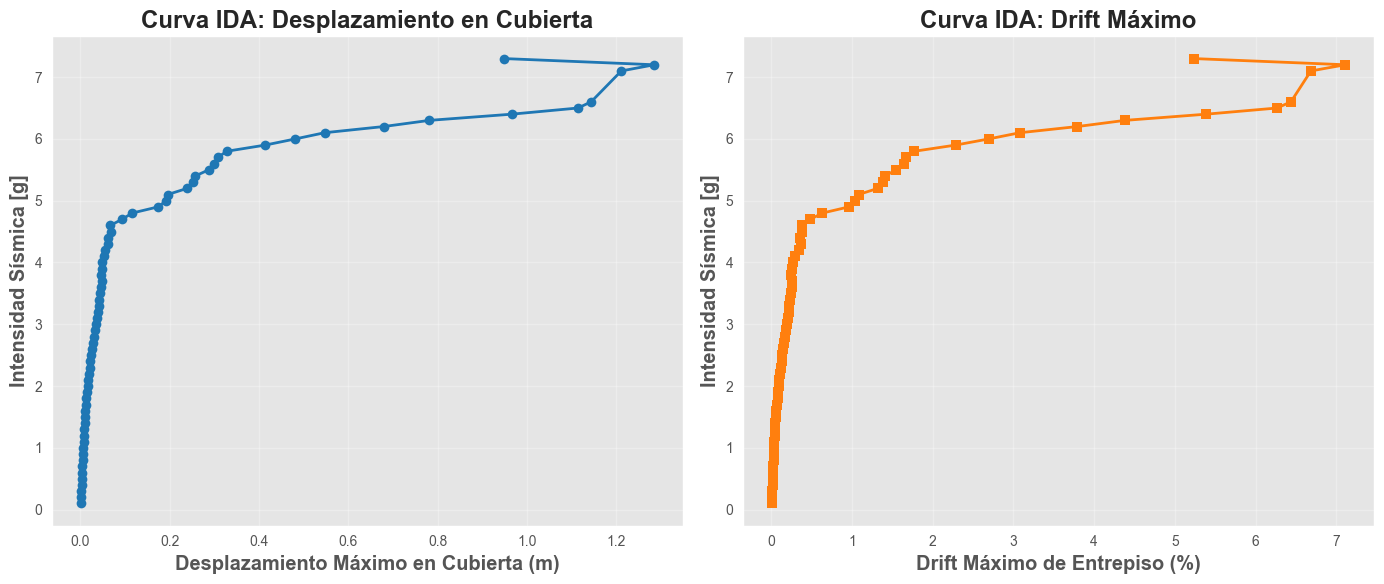

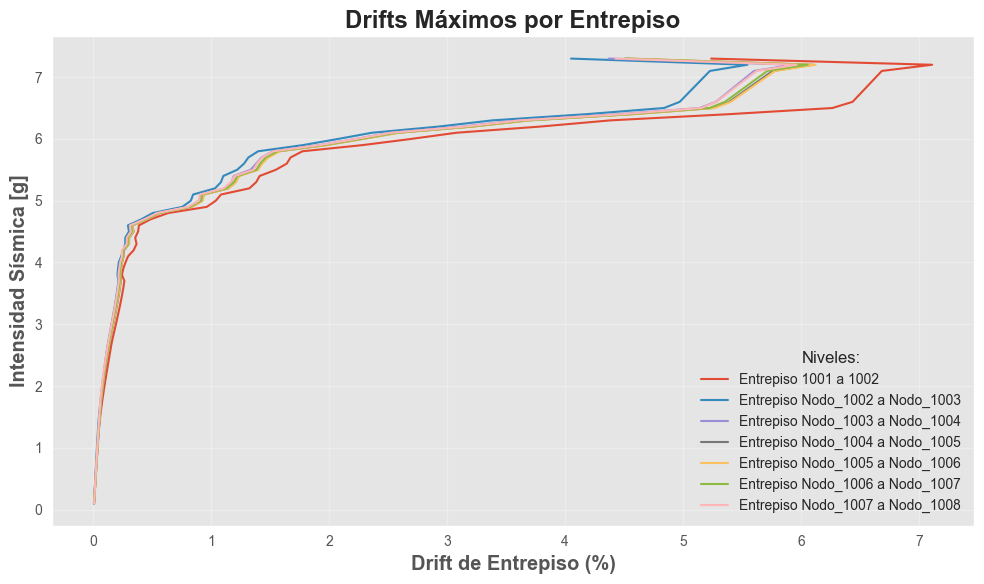


‚úÖ Proceso completado exitosamente!
Resultados disponibles en:
- Archivos CSV convertidos: ./Resultados_CSV/
- Resumen de resultados: ./Resultados_Procesados/Resumen_IDA.csv
- Gr√°ficos: ./Resultados_Procesados/Curvas_IDA_*.png


In [72]:
def convertir_txt_a_csv():
    """Convierte todos los archivos TXT de resultados a formato CSV"""
    Path("Resultados_CSV").mkdir(exist_ok=True)
    
    for archivo in os.listdir():
        if archivo.startswith("Diafragmas_IDA_UX_") and archivo.endswith(".txt"):
            try:
                data = pd.read_csv(archivo, delim_whitespace=True, header=None)
                num_nodos = data.shape[1]
                data.columns = [f'Nodo_{1001+i}' for i in range(num_nodos)]
                
                nombre_csv = archivo.replace('.txt', '.csv')
                data.to_csv(f"Resultados_CSV/{nombre_csv}", index=False)
                print(f"‚úì Convertido: {archivo} ‚Üí Resultados_CSV/{nombre_csv}")
            except Exception as e:
                print(f"‚úó Error al convertir {archivo}: {str(e)}")

def calcular_drifts_correctos(data, dz):
    """
    Calcula drifts de entrepiso considerando:
    - Primer entrepiso: (Nodo_1002 - 0) ya que el suelo no se mueve
    - Dem√°s entrepisos: (Nodo_superior - Nodo_inferior)
    """
    drifts = pd.DataFrame()
    num_nodos = len(data.columns)
    
    # Primer entrepiso (Nodo_1002 - 0)
    if num_nodos >= 1:
        drifts['Drift_1001-1002'] = (data['Nodo_1002'] - 0).abs() / dz * 100
    
    # Resto de entrepisos
    for i in range(2, num_nodos):
        nodo_inf = f'Nodo_{1000+i}'
        nodo_sup = f'Nodo_{1001+i}'
        drifts[f'Drift_{nodo_inf}-{nodo_sup}'] = (data[nodo_sup] - data[nodo_inf]).abs() / dz * 100
    
    return drifts

def procesar_resultados_ida(dz, output_dir="Resultados_Procesados"):
    Path(output_dir).mkdir(exist_ok=True)
    resultados = []
    
    for archivo in os.listdir("Resultados_CSV"):
        if archivo.startswith("Diafragmas_IDA_UX_") and archivo.endswith(".csv"):
            try:
                GMfact = float(archivo.split('_')[-1].replace('.csv', ''))
                data = pd.read_csv(f"Resultados_CSV/{archivo}")
                num_nodos = len(data.columns)
                
                # 1. Desplazamiento m√°ximo en nodo m√°s alto
                nodo_mas_alto = data.columns[-1]
                max_disp = data[nodo_mas_alto].abs().max()
                
                # 2. C√°lculo CORRECTO de drifts
                if num_nodos >= 1:
                    drifts = calcular_drifts_correctos(data, dz)
                    max_drift = drifts.max().max()
                    drift_por_entrepiso = {col: drifts[col].max() for col in drifts.columns}
                else:
                    max_drift = np.nan
                    drift_por_entrepiso = {}
                
                resultados.append({
                    'IM': GMfact,
                    'MaxDisp': max_disp,
                    'MaxDrift': max_drift,
                    **drift_por_entrepiso,
                    'Archivo': archivo  # Para referencia
                })
                
            except Exception as e:
                print(f"‚úó Error procesando {archivo}: {str(e)}")
    
    # Ordenar por intensidad y guardar
    df_resultados = pd.DataFrame(resultados).sort_values('IM')
    df_resultados.to_csv(f"{output_dir}/Resumen_IDA.csv", index=False, float_format='%.6f')
    
    # Generar gr√°ficos
    generar_graficos(df_resultados, output_dir)
    
    return df_resultados

def generar_graficos(df, output_dir):
    """Genera gr√°ficos profesionales con los resultados"""
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [14, 6]
    plt.rcParams['font.size'] = 12
    
    if df.empty:
        print("‚ö†Ô∏è No hay datos para graficar")
        return
    
    # Gr√°fico 1: Curvas IDA principales
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    # Desplazamiento en cubierta
    ax1.plot(df['MaxDisp'], df['IM'], 'o-', color='#1f77b4', linewidth=2)
    ax1.set_xlabel('Desplazamiento M√°ximo en Cubierta (m)', fontweight='bold')
    ax1.set_ylabel('Intensidad S√≠smica [g]', fontweight='bold')
    ax1.set_title('Curva IDA: Desplazamiento en Cubierta', fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Drift m√°ximo
    ax2.plot(df['MaxDrift'], df['IM'], 's-', color='#ff7f0e', linewidth=2)
    ax2.set_xlabel('Drift M√°ximo de Entrepiso (%)', fontweight='bold')
    ax2.set_ylabel('Intensidad S√≠smica [g]', fontweight='bold')
    ax2.set_title('Curva IDA: Drift M√°ximo', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/Curvas_IDA_Principales.png", dpi=300)
    plt.show()
    
    # Gr√°fico 2: Drifts por entrepiso
    drift_cols = [col for col in df if col.startswith('Drift_')]
    if drift_cols:
        fig, ax = plt.subplots(figsize=(10, 6))
        
        for col in drift_cols:
            label = col.replace('Drift_', 'Entrepiso ').replace('-', ' a ')
            ax.plot(df[col], df['IM'], '-', label=label, linewidth=1.5)
        
        ax.set_xlabel('Drift de Entrepiso (%)', fontweight='bold')
        ax.set_ylabel('Intensidad S√≠smica [g]', fontweight='bold')
        ax.set_title('Drifts M√°ximos por Entrepiso', fontweight='bold')
        ax.legend(title="Niveles:")
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f"{output_dir}/Drifts_por_Entrepiso.png", dpi=300)
        plt.show()

# Ejecuci√≥n principal
if __name__ == "__main__":
    print("üîÑ Convirtiendo archivos TXT a CSV...")
    convertir_txt_a_csv()
    
    print("\nüìä Procesando resultados IDA...")
    dz = 3.0  # Altura entre pisos en metros (AJUSTAR ESTE VALOR)
    df_resultados = procesar_resultados_ida(dz)
    
    print("\n‚úÖ Proceso completado exitosamente!")
    print("Resultados disponibles en:")
    print(f"- Archivos CSV convertidos: ./Resultados_CSV/")
    print(f"- Resumen de resultados: ./Resultados_Procesados/Resumen_IDA.csv")
    print(f"- Gr√°ficos: ./Resultados_Procesados/Curvas_IDA_*.png")